# Shared libraries and packages

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from sklearn.metrics import mean_squared_error

/home/rdcarini/Documents/Projects/pysindy-venv/AMATH575/.venv/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [26]:
np.__version__

'1.26.4'

# "Final" Code

# Draft / Playground space below:

## Clayton Code

## Jackie Code

## Max Code

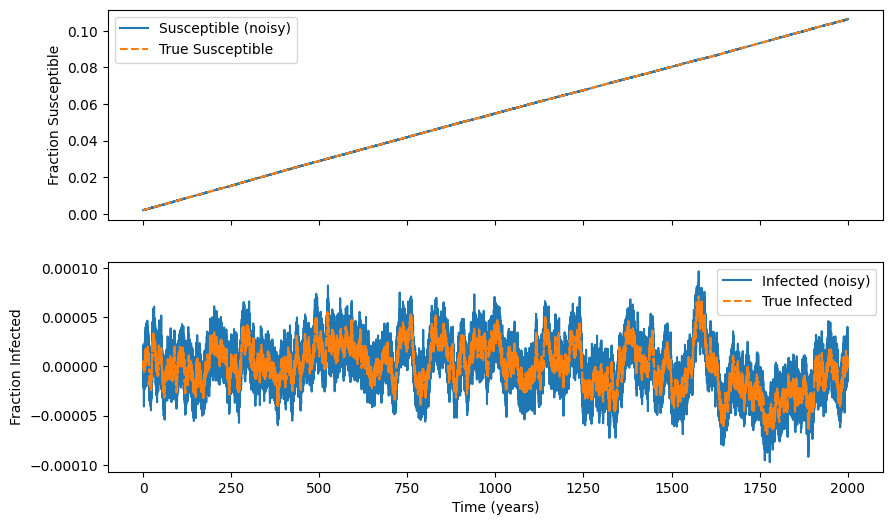

(S)[k+1] = 1.000 f0(S[k]) + 0.281 f0(I[k]) + -4.050 f1(S[k],I[k]) + -0.007 f1(S[k],beta[k]) + -18.358 f1(I[k],beta[k]) + 262.966 f2(S[k],I[k],beta[k])
(I)[k+1] = 0.672 f0(I[k]) + -1.207 f1(S[k],I[k]) + 0.010 f1(S[k],beta[k]) + 0.144 f1(I[k],beta[k]) + 216.072 f2(S[k],I[k],beta[k])
(beta)[k+1] = 0.221 f0(S[k]) + 101.444 f0(I[k]) + 1.000 f0(beta[k]) + -215.673 f1(S[k],I[k]) + -14.364 f1(S[k],beta[k]) + -6598.363 f1(I[k],beta[k]) + 14075.393 f2(S[k],I[k],beta[k])


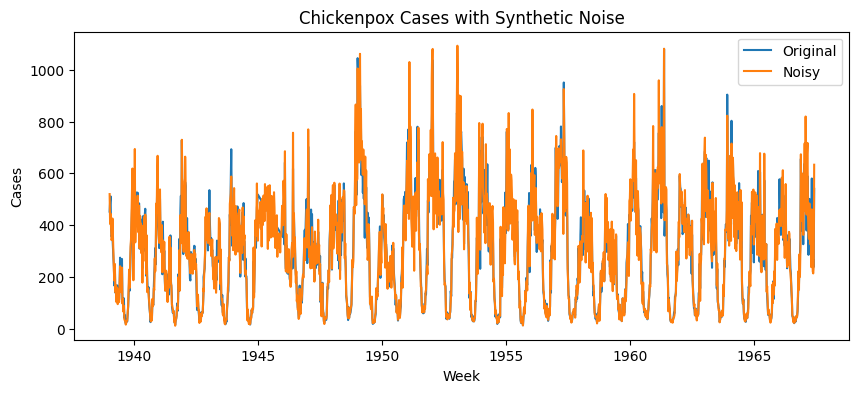

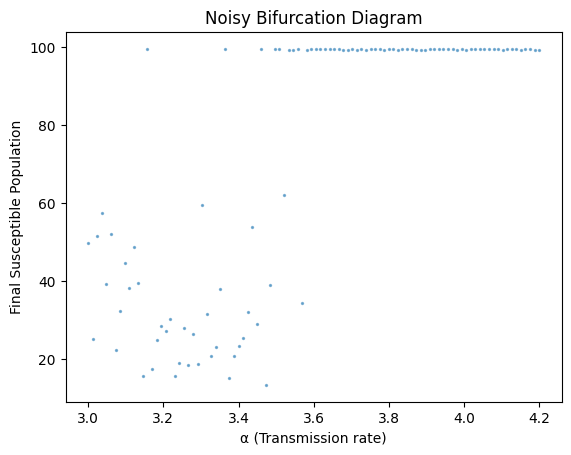

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.io import loadmat
import pandas as pd

##############################
# Synthetic SIR Model with Noise
##############################

# Simulation parameters
num_years = 2000
weeks_per_year = 52
total_weeks = num_years * weeks_per_year

# Noise parameters (adjust these to study noise effects)
process_noise_level = 1e-6  # Additive process noise amplitude
measurement_noise_level = 1e-5  # Measurement noise for observables
beta_noise_level = 0.01  # Multiplicative noise for transmission rate

# Initial conditions
S0 = 0.002
I0 = 0.0

# Model parameters
beta0 = 0.8 / weeks_per_year
beta1 = 0.025 / weeks_per_year
gamma = 0.1 / weeks_per_year
phi = 0.0
mu = 5.4795e-5 / weeks_per_year
nu = 5.4795e-5 / weeks_per_year

# Time array
t = np.linspace(0, num_years, total_weeks)

# Initialize arrays
beta = np.zeros_like(t)
S = np.zeros_like(t)
I = np.zeros_like(t)

# Set initial conditions
S[0] = S0
I[0] = I0

# Generate noise arrays
np.random.seed(0)
process_noise_S = process_noise_level * np.random.randn(total_weeks)
process_noise_I = process_noise_level * np.random.randn(total_weeks)
beta_noise = 1 + beta_noise_level * np.random.randn(total_weeks)

# Simulation loop
for week in range(total_weeks - 1):
    # Time-varying transmission rate with multiplicative noise
    beta[week] = beta0 * (1.0 + beta1 * np.cos(2*np.pi*week/weeks_per_year - phi)) * beta_noise[week]
    
    # Update equations with process noise
    S[week+1] = S[week] + nu - beta[week]*S[week]*I[week] - mu*S[week] + process_noise_S[week]
    I[week+1] = I[week] + beta[week]*S[week]*I[week] - gamma*I[week] - mu*I[week] + process_noise_I[week]

# Add measurement noise to observables
measurement_noise_S = measurement_noise_level * np.random.randn(total_weeks)
measurement_noise_I = measurement_noise_level * np.random.randn(total_weeks)
S_obs = S + measurement_noise_S
I_obs = I + measurement_noise_I

# Plot noisy system
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax1.plot(t, S_obs, label='Susceptible (noisy)')
ax1.plot(t, S, '--', label='True Susceptible')
ax1.set_ylabel('Fraction Susceptible')
ax1.legend()

ax2.plot(t, I_obs, label='Infected (noisy)')
ax2.plot(t, I, '--', label='True Infected')
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Fraction Infected')
ax2.legend()
plt.show()

##############################
# SINDy Model Identification
##############################

# Create input matrix including transmission rate
X = np.vstack([S_obs, I_obs, beta]).T

# Custom library to capture SIR dynamics
library_functions = [
    lambda x: x,  # Identity
    lambda x,y: x*y,  # Interaction term
    lambda x,y,z: x*y*z  # Higher-order interaction
]

library_feature_names = [
    'S', 'I', 'beta',
    'S*I', 'S*beta', 'I*beta',
    'S*I*beta'
]

# Build custom library
custom_lib = ps.CustomLibrary(
    library_functions=library_functions,
)

# Robust differentiation method for noisy data
differentiation_method = ps.SmoothedFiniteDifference(
    smoother_kws={'window_length': 7},
    order=2
)

# Sparse regression with thresholding
optimizer = ps.STLSQ(threshold=1e-5, alpha=1e-3, normalize_columns=True)

# Create and fit SINDy model
model = ps.SINDy(
    feature_library=custom_lib,
    differentiation_method=differentiation_method,
    optimizer=optimizer,
    feature_names=['S', 'I', 'beta'],
    discrete_time=True
)

model.fit(X, t=t[1]-t[0])
model.print()

##############################
# Real Disease Data Analysis
##############################

# Load and preprocess real data
def load_disease_data(path):
    data = pd.read_csv(path, sep="\t", header=None)
    data.columns = ["week", "cases"]
    data["cases"] = data["cases"].interpolate()
    return data

# Add synthetic noise to real data
def add_measurement_noise(data, noise_level=0.1):
    noisy_data = data.copy()
    noise = noise_level * np.abs(data["cases"]) * np.random.randn(len(data))
    noisy_data["cases"] = data["cases"] + noise
    return noisy_data

# Analyze chickenpox data with added noise
chickenpox = load_disease_data('data/OntarioChickenWeekly39_69.txt')
chickenpox_noisy = add_measurement_noise(chickenpox, 0.15)

# Plot noisy real data
plt.figure(figsize=(10, 4))
plt.plot(chickenpox["week"], chickenpox["cases"], label='Original')
plt.plot(chickenpox_noisy["week"], chickenpox_noisy["cases"], label='Noisy')
plt.xlabel('Week')
plt.ylabel('Cases')
plt.title('Chickenpox Cases with Synthetic Noise')
plt.legend()
plt.show()

##############################
# Bifurcation Analysis with Noise
##############################

def noisy_bifurcation_analysis():
    alpha_vals = np.linspace(3, 4.2, 100)
    S_final = []
    
    for alpha in alpha_vals:
        S, I = 70., 30.
        for _ in range(1000):
            # Add noise to parameters
            noisy_beta = 0.8 + 0.1*np.random.randn()
            noisy_alpha = alpha + 0.05*np.random.randn()
            
            S_new = (1 - 0.005)*S - (noisy_alpha/100)*I*S + noisy_beta*(100 - S)
            I_new = (noisy_alpha/100)*I*S + (1 - noisy_beta - 0.1)*I
            
            S, I = max(0, S_new), max(0, I_new)
            
        S_final.append(S)
    
    plt.scatter(alpha_vals, S_final, s=2, alpha=0.5)
    plt.xlabel('α (Transmission rate)')
    plt.ylabel('Final Susceptible Population')
    plt.title('Noisy Bifurcation Diagram')
    plt.show()

noisy_bifurcation_analysis()

## Gaurav Code

In [ ]:
!pip install numpy pandas scipy pysindy scikit-learn matplotlib requests

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint, solve_ivp
from scipy.signal import savgol_filter, detrend, welch, windows
from scipy.io import loadmat
from io import BytesIO
import requests

import pysindy as ps
from pysindy.optimizers import STLSQ
from sklearn.metrics import r2_score
from pysindy.feature_library import PolynomialLibrary

In [74]:
beta0, beta1 = 400.0, 200.0       # transmission baseline & seasonal amp
gamma       = 1/10.0             # recovery rate (1/week)
mu          = 1/(70*52.0)        # birth/death rate
N           = 1e6                # total population
phi         = 0.0                # seasonal phase
period      = 52                 # weeks per year
noise_amp   = 1e-5               # SIR noise level
seed        = 42                 # RNG seed

# time grid: 20 years of weekly points
t_sim = np.linspace(0, 20*period, 20*period + 1)
y0    = [0.99*N, 0.01*N, 0.0]     # initial [S, I, R]

In [75]:
!mkdir -p data

!wget -q https://raw.githubusercontent.com/jonathanhorrocks/SINDy-data/master/Horrocks_Repo/data/mDataFM_N.mat \
     -O data/mDataFM_N.mat

!wget -q https://raw.githubusercontent.com/jonathanhorrocks/SINDy-data/master/Horrocks_Repo/data/OntarioChickenWeekly39_69.txt \
     -O data/OntarioChickenWeekly39_69.txt

!wget -q https://raw.githubusercontent.com/jonathanhorrocks/SINDy-data/master/Horrocks_Repo/data/OntarioRubellaWeekly39_69.txt \
     -O data/OntarioRubellaWeekly39_69.txt

!ls -1 data

mDataEW_N.mat
mDataFM_N.mat
Ontario_Birth_Data_M.txt
OntarioChickenWeekly39_69.txt
Ontario_Demographics_Measles.txt
OntarioRubellaWeekly39_69.txt


In [80]:
measles = pd.DataFrame(
    loadmat('data/mDataEW_N.mat')['mDataN'],
    columns=['week','cases','population','births']
)

chickenpox = pd.read_csv(
    'data/OntarioChickenWeekly39_69.txt', sep='\t',
    header=None, names=['week','cases']
)
chickenpox['births']     = np.random.poisson(1500, len(chickenpox))
chickenpox['population'] = np.linspace(2e6,2.5e6,len(chickenpox))

rubella = pd.read_csv(
    'data/OntarioRubellaWeekly39_69.txt', sep='\t',
    header=None, names=['week','cases']
)
rubella['births']     = np.random.poisson(1200, len(rubella))
rubella['population'] = np.linspace(1.8e6,2.2e6,len(rubella))


def load_data(disease_name):
    """Loads the specified disease data."""
    if disease_name == 'measles':
        return measles
    elif disease_name == 'chickenpox':
        return chickenpox
    elif disease_name == 'rubella':
        return rubella
    else:
        raise ValueError(f"Unknown disease: {disease_name}")


print("Loaded:",
      len(measles),"measles rows;",
      len(chickenpox),"chickenpox rows;",
      len(rubella),"rubella rows")

Loaded: 991 measles rows; 1484 chickenpox rows; 1534 rubella rows


In [ ]:
def simulate_sir_seasonal(t, y0, beta0, alpha, gamma, mu, N, phi, period=52):
    def rhs(tt, y):
        S, I, R = y
        βt = beta0 * (1 + alpha * np.cos(2*np.pi*tt/period + phi))
        return [
            mu*(N - S)   - βt * S * I / N,
            βt * S * I / N - (gamma + mu) * I,
            gamma * I    - mu * R
        ]
    sol = solve_ivp(rhs, [t[0], t[-1]], y0, t_eval=t,
                    method='LSODA', rtol=1e-8, atol=1e-10)
    return sol.y  # shape (3,len(t))

def reconstruct_S_finkenstadt(cases, births, N_series, d_shift=5, window=52):
    C = np.cumsum(cases)
    B = np.cumsum(births)
    n = len(C)
    # shift births
    B_shift = np.empty(n)
    B_shift[:d_shift] = B[0]
    B_shift[d_shift:] = B[:-d_shift]
    # global fit (closed form)
    Cm, Bm = C.mean(), B_shift.mean()
    num = np.sum((C-Cm)*(B_shift-Bm))
    den = np.sum((C-Cm)**2)
    α, b0 = num/den, Bm - (num/den)*Cm
    # residual + rolling mean
    Z = B_shift - (α*C + b0)
    Zs = pd.Series(Z).rolling(window, center=True, min_periods=1).mean().values
    # reconstruct with dynamic N
    S_hat = N_series - C + Zs
    return np.clip(S_hat, 0, None)  # allow S ≤ N, but ≥ 0

def recover_beta(S, pre, t, gamma, mu, N, wI=15,oI=3,wB=31,oB=3):
    I_s = savgol_filter(pre, wI, oI)
    I_s = np.maximum(I_s,1e-6)
    dI  = np.gradient(I_s, t)
    denominator = S * I_s
    denominator[np.abs(denominator) < 1e-12] = 1e-12 # Use a small value to prevent inf/nan
    β   = (dI + (gamma+mu)*I_s)*N/denominator
    return savgol_filter(β, wB, oB)

def psd(ts, fs=1.0, taper=0.2):
    n = max(1,int(len(ts)*taper))
    window = windows.hann(n)
    f,P = welch(ts, fs=fs, nperseg=n, window=window)
    return f,P
power_spectral_density = psd


def run_sindy(X, t, dX=None, degree=2, threshold=1e-2):
    lib = ps.PolynomialLibrary(degree=degree)
    opt = STLSQ(threshold=threshold)
    model = ps.SINDy(feature_library=lib, optimizer=opt,
                     differentiation_method=None if dX is not None else 'finite_difference')
    if dX is None:
        model.fit(X, t=t)
    else:
        model.fit(X, t=t, x_dot=dX)
    return model

Points after crop: 1041 1041


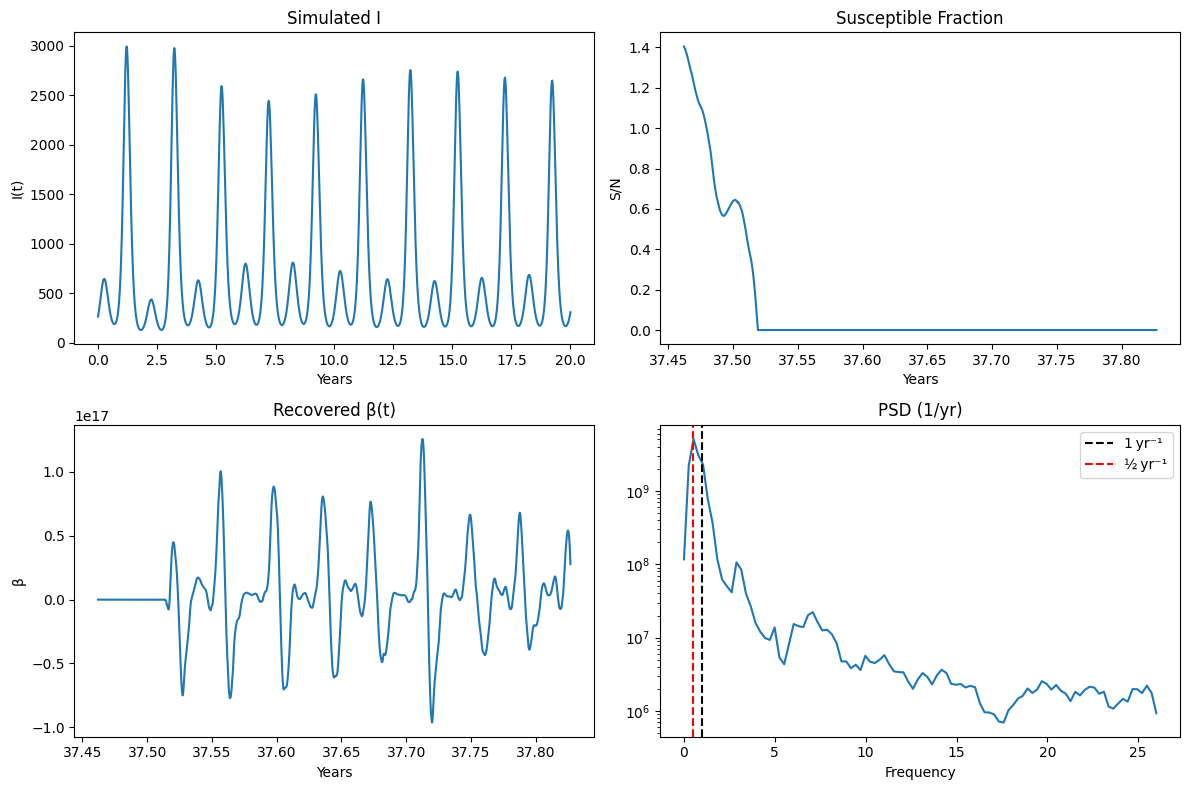

In [82]:
beta0, alpha = 400/52, 0.2
gamma, mu    = 0.5, 1/(50*52)
N            = 1e6
phi, period  = 0.0, 52

cases  = measles['cases'].values
births = measles['births'].values

t_long = np.linspace(0,40*period,40*period+1)
y0_eq   = [ (gamma+mu)/beta0 * N, 1.0, N - (gamma+mu)/beta0 * N - 1.0 ]
S_long,I_long,_ = simulate_sir_seasonal(
    t_long, y0_eq, beta0,alpha,gamma,mu,N,phi,period
)

spin   = int(20*period)
t_sim  = t_long[spin:] - t_long[spin]    # 0 → 20*52
years  = t_sim/52.0                     # in years
I_sim  = I_long[spin:]

print("Points after crop:", len(years), len(I_sim))

S_hat  = reconstruct_S_finkenstadt(cases, births, N)
s_frac = S_hat/N
weeks  = measles['week'].values
beta_t = recover_beta(S_hat, cases/N, weeks, gamma, mu, N)
f_wk,Pxx= psd(cases,fs=1.0,taper=0.2)
f_yr    = f_wk*52

fig,axs=plt.subplots(2,2,figsize=(12,8))

axs[0,0].plot(years, I_sim)
axs[0,0].set(title="Simulated I",xlabel="Years",ylabel="I(t)")

axs[0,1].plot(weeks/52.0, s_frac)
axs[0,1].set(title="Susceptible Fraction",xlabel="Years",ylabel="S/N")

axs[1,0].plot(weeks/52.0, beta_t)
axs[1,0].set(title="Recovered β(t)",xlabel="Years",ylabel="β")

axs[1,1].semilogy(f_yr,Pxx)
axs[1,1].axvline(1,ls='--',c='k',label='1 yr⁻¹')
axs[1,1].axvline(0.5,ls='--',c='r',label='½ yr⁻¹')
axs[1,1].set(title="PSD (1/yr)",xlabel="Frequency")
axs[1,1].legend()

plt.tight_layout()
plt.show()


----- MEASLES minimal S–I discovery -----
dS/dt = 0.0428·1 + -0.0573·S + -0.0000·I
dI/dt = -0.0001·1 + 0.0000·S


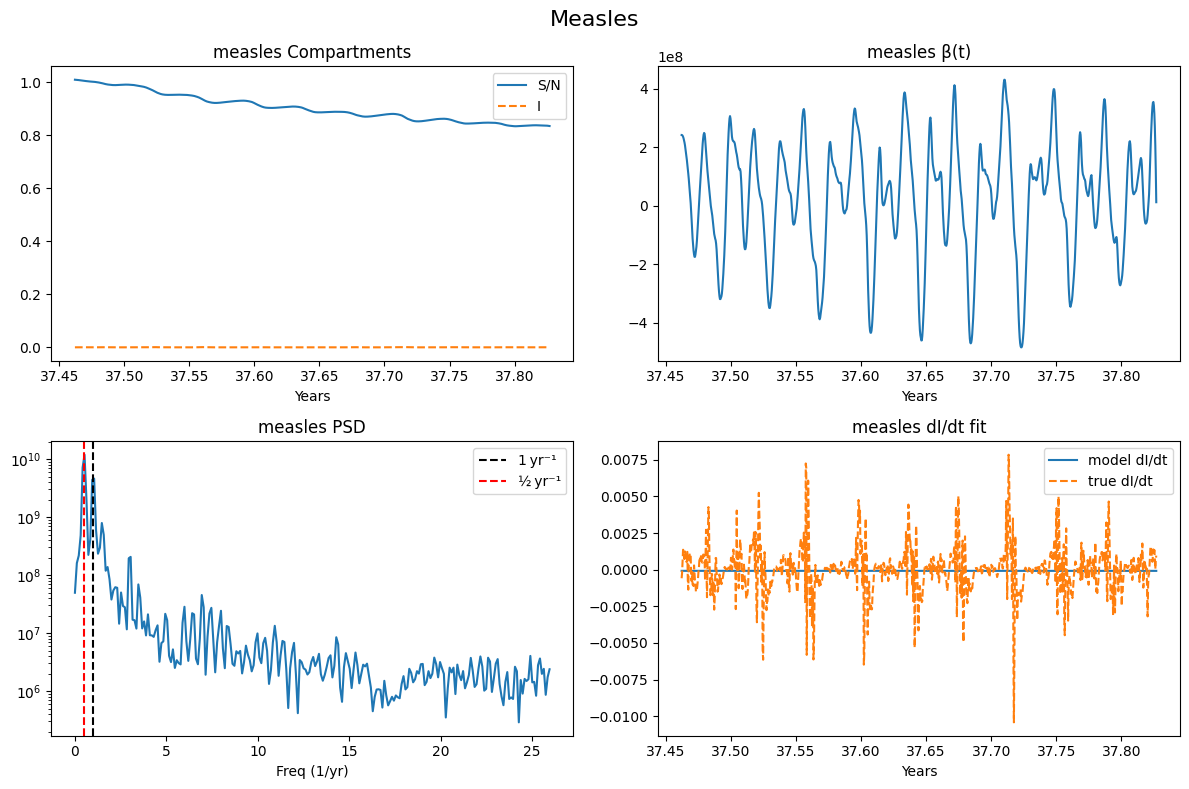


----- CHICKENPOX minimal S–I discovery -----
dS/dt = 
dI/dt = 


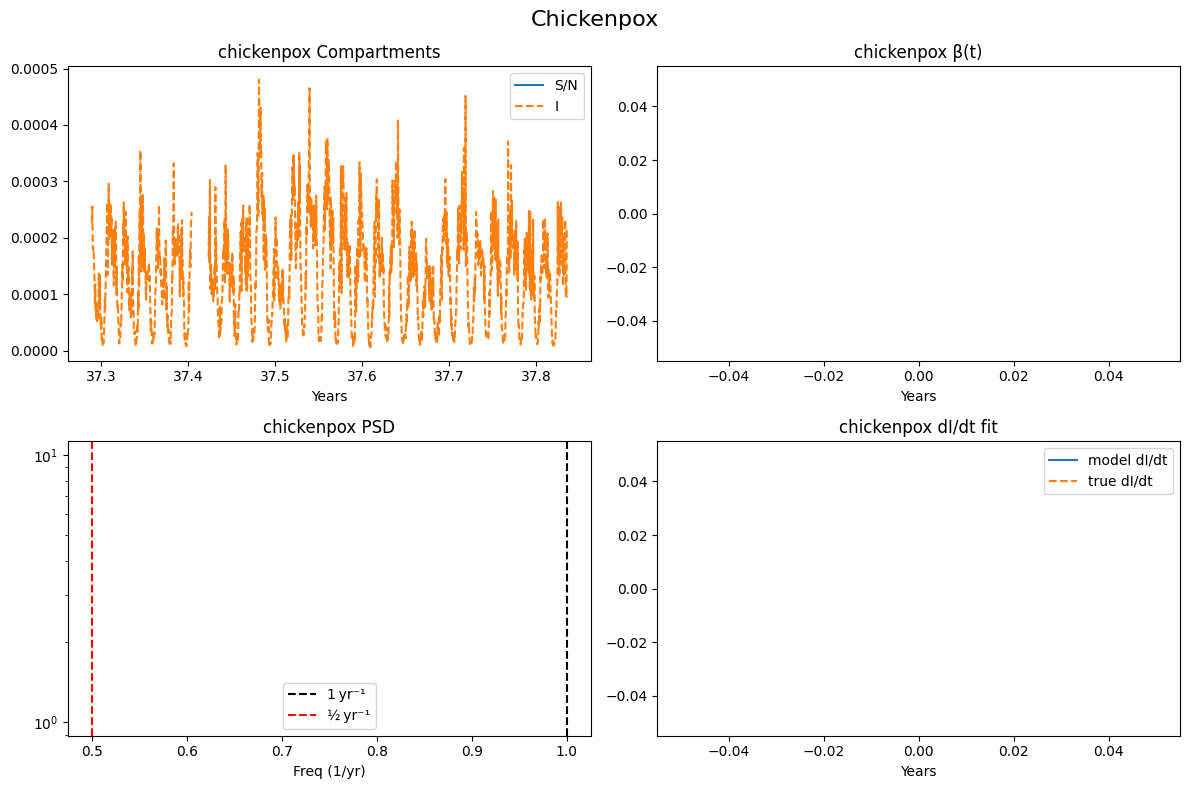


----- RUBELLA minimal S–I discovery -----
dS/dt = 
dI/dt = 


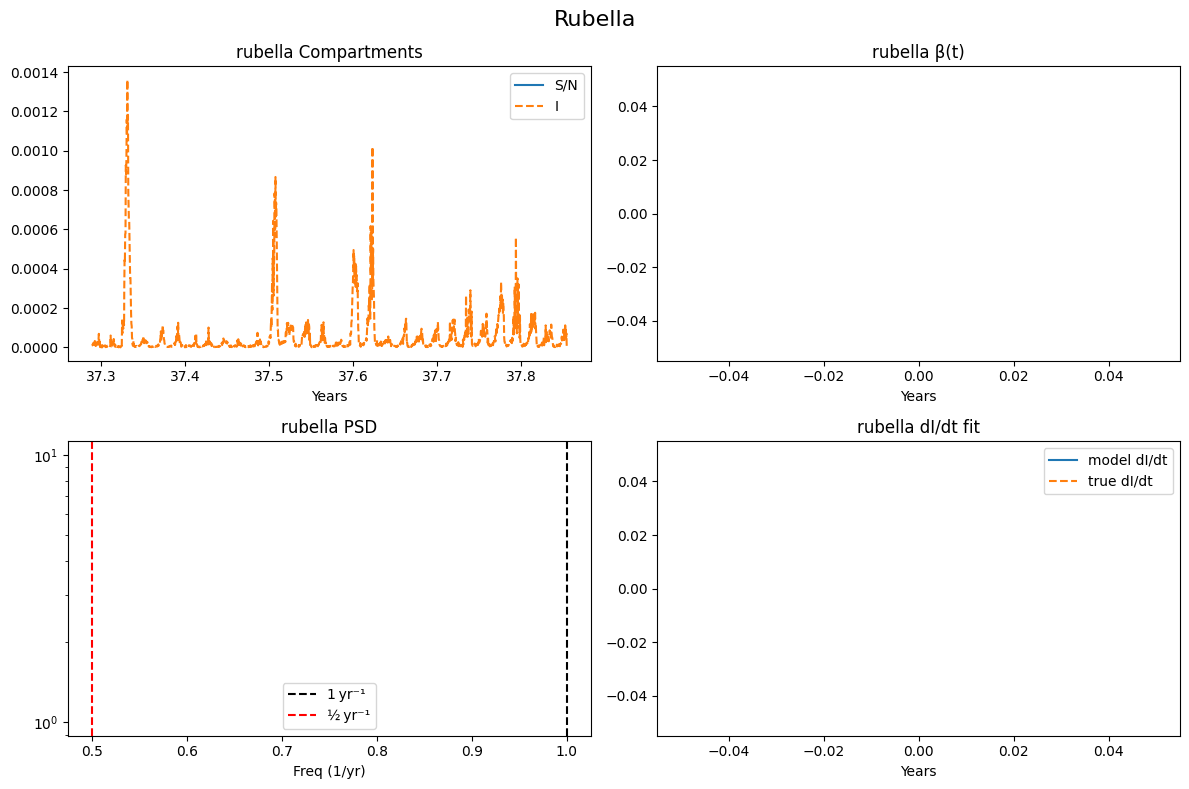

In [83]:
def analyze_disease_minimal(df, disease, threshold=1e-6, ridge_alpha=1e-6):

    t_wk = df.week.values
    t_yr = t_wk / 52.0
    cases     = df.cases.values
    births    = df.births.values
    N_series  = df.population.values
    gamma, mu = 0.5, 1/(50*52)

    # reconstruct & prevalence
    S_hat  = reconstruct_S_finkenstadt(cases, births, N_series)
    s_frac = S_hat / N_series
    I_pre  = cases / N_series

    # recover β(t)
    beta_t = recover_beta(s_frac, I_pre, t_wk, gamma, mu, N_series)

    # PSD
    f_wk, Pxx = welch(cases, fs=1, nperseg=min(1024, len(cases)//2))
    f_yr      = f_wk * 52

    # derivatives
    dS = np.gradient(s_frac, t_wk)
    dI = np.gradient(I_pre,  t_wk)

    # build minimal library Θ = [1, S, I, β·S·I]
    ones = np.ones_like(s_frac)
    Θ    = np.column_stack([ones, s_frac, I_pre, beta_t*s_frac*I_pre])
    names= ['1','S','I','βSI']

    # mask bad rows
    ok   = np.isfinite(Θ).all(1) & np.isfinite(dS) & np.isfinite(dI)
    Θm   = Θ[ok]
    dSm  = dS[ok]
    dIm  = dI[ok]

    # normal equations solve (4×4 invert)
    Dm = np.vstack([dSm, dIm]).T     # (m,2)
    M  = Θm.T @ Θm                   # (4,4)

    # Add ridge regularization to M to handle potential singularity
    M_reg = M + ridge_alpha * np.eye(M.shape[0])

    B  = Θm.T @ Dm                   # (4,2)

    Xi, residuals, rank, s = np.linalg.lstsq(M_reg, B, rcond=None)

    Xi[np.abs(Xi) < threshold] = 0.0

    print(f"\n----- {disease.upper()} minimal S–I discovery -----")
    for col, eqn in enumerate(['dS/dt','dI/dt']):
        terms = [f"{Xi[i,col]:.4f}·{names[i]}" for i in range(4) if Xi[i,col]!=0]
        print(f"{eqn} = " + " + ".join(terms))

    # plot
    fig, axs = plt.subplots(2,2,figsize=(12,8))
    axs[0,0].plot(t_yr, s_frac,   label='S/N')
    axs[0,0].plot(t_yr, I_pre, '--', label='I')
    axs[0,0].set(title=f"{disease} Compartments", xlabel="Years")
    axs[0,0].legend()

    axs[0,1].plot(t_yr, beta_t)
    axs[0,1].set(title=f"{disease} β(t)", xlabel="Years")

    axs[1,0].semilogy(f_yr, Pxx)
    axs[1,0].axvline(1,   ls='--', c='k', label='1 yr⁻¹')
    axs[1,0].axvline(0.5, ls='--', c='r', label='½ yr⁻¹')
    axs[1,0].set(title=f"{disease} PSD", xlabel="Freq (1/yr)")
    axs[1,0].legend()


    preds = Θm @ Xi[:,1]
    axs[1,1].plot(t_yr[ok], preds,     label='model dI/dt')
    axs[1,1].plot(t_yr[ok], dIm, '--', label='true dI/dt')
    axs[1,1].set(title=f"{disease} dI/dt fit", xlabel="Years")
    axs[1,1].legend()

    plt.suptitle(disease.capitalize(), fontsize=16)
    plt.tight_layout()
    plt.show()

    return Xi


models = {}
for name, df in zip(
    ['measles','chickenpox','rubella'],
    [measles, chickenpox, rubella]
):

    models[name] = analyze_disease_minimal(df, name, ridge_alpha=1e-6)

## Richard Code

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter, detrend, welch, windows

### Model Discovery from SIR Simulated Data

Explanation taken from "Model rediscovery from simulated data" [of original paper](https://www.nature.com/articles/s41598-020-63877-w#data-availability)
$$S_{t+1} = S_t + \nu - \beta (t) S_t I_t - \mu S_t,$$
$$I_{t+1} = I_t + \beta (t) S_t I_t - \gamma I_t - \mu I_t$$
$$R_{t+1} = R_t + \gamma I_t - \mu R_t$$

$S_t(I_t, R_t)$ is number of susceptible persons, $t$ is timestep, $\nu$ (resp. $\mu$) is the per capita birth (resp. death) rate per timestep, $\gamma$ is the per capita recovery rate per timestep, and $\beta(t)$ is the seasonally-varing transmission rate with form given by:

$$\beta(t) = \beta_0 (1 + \beta_1 \cos(2 \pi t/ T - \phi))$$ 

$T = 1$ year is period of oscillation, $\phi$ is a phase shift with seasonal behavior of the transmission rate. $t \approx$ one week for the paper

##### Intro example on how SIR model works

Constants used: 
\begin{align*}
S_0 &= 0.2\\
I_0 &\approx 0\\
\beta_0 &= 0.8 / 52\\
\beta_1 &= 0.025 / 52\\
\gamma &= 0.2 / 52\\
\phi &= \pi \times 0\\
\nu &= \mu = (5.4795\times 10e-5) / 52\\
\end{align*}

In [2]:
num_years = 2000
weeks_per_year = 52

# Initial conditions:
S_0 = 0.2
I_0 = 0
beta_0 = 0.8 / weeks_per_year
beta_1 = 0.025 / weeks_per_year
gamma = 0.2 / weeks_per_year          # per capita recovery rate
phi = np.pi * 0.                      # seasonal phase shift

mu = 5.4795*10e-5 / weeks_per_year # birth rate
nu = 5.4795*10e-5 / weeks_per_year # death rate

t = np.linspace(0, num_years, num_years * weeks_per_year)
beta = np.zeros(len(t))
S = np.zeros(len(t))
I = np.zeros(len(t))

np.random.seed(0)
noiseS = 10e-7 * np.random.randn(1,len(t)).squeeze()
noiseI = 10e-7 * np.random.randn(1,len(t)).squeeze()

S[0] = S_0
I[0] = I_0

for week in range(0,len(t)-1):
    beta[week] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(week)/(1 / float(weeks_per_year)) - phi))
    S[week+1] = max(0, S[week] + nu - beta[week] * S[week] * I[week] - mu * S[week] + noiseS[week])
    I[week+1] = max(0, I[week] + beta[week] * S[week] * I[week] - gamma * I[week] - mu * I[week] + noiseI[week])

beta[len(t)-1] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(t[-1])/ ( 1 / float(weeks_per_year)) - phi))

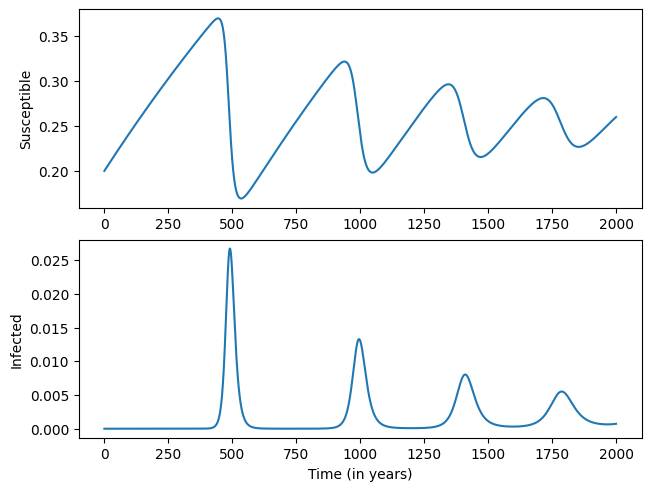

In [11]:
##############################
# Plot data
##############################

fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

ax1.plot(t,S)
ax1.set_ylabel('Susceptible')
ax1.set_title('')

ax2.plot(t,I)
ax2.set_xlabel('Time (in years)')
ax2.set_ylabel('Infected')
ax2.set_title('')
plt.show()

#### Some helper functions to make various SIR models

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps

def generate_SIR(S_init = 0.2, I_init = 10e-10):
    ##############################
    # Generate an SIR model
    # Returns: S and I evolved over time
    ##############################

    num_years = 2000
    weeks_per_year = 52

    # Initial conditions:
    S_0 = S_init
    I_0 = I_init
    beta_0 = 0.8 / weeks_per_year
    beta_1 = 0.025 / weeks_per_year
    gamma = 0.2 / weeks_per_year          # per capita recovery rate
    phi = np.pi * 0.                      # seasonal phase shift

    mu = 5.4795*10e-5 / weeks_per_year # birth rate
    nu = 5.4795*10e-5 / weeks_per_year # death rate

    t = np.linspace(0, num_years, num_years * weeks_per_year)
    beta = np.zeros(len(t))
    S = np.zeros(len(t))
    I = np.zeros(len(t))

    S[0] = S_0
    I[0] = I_0

    for week in range(0,len(t)-1):
        beta[week] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(week)/(1/weeks_per_year) - phi))
        S[week+1] = S[week] + nu - beta[week] * S[week] * I[week] - mu * S[week]
        I[week+1] = I[week] + beta[week] * S[week] * I[week] - gamma * I[week] - mu * I[week]

    beta[len(t)-1] = beta_0 * (1.0 + beta_1 * np.cos(2.0*np.pi*float(t[-1]) - phi))
    
    return t, S, I, beta


def add_noise(S, I, additive_noise_level = 1e-50):

    ##############################
    # Add noise to S and I
    # Returns: A Noisy version of S and I
    ##############################

    np.random.seed(0)
    noiseS = additive_noise_level * np.random.randn(1,len(t)).squeeze()
    noiseI = additive_noise_level * np.random.randn(1,len(t)).squeeze()

    return S + noiseS, I + noiseI


def apply_sindy(S, I, t, beta, threshold=10e-3):

    ##############################
    # Construct SINDy model for SIR
    # Returns: Trained Model
    ##############################

    poly_lib1 = ps.PolynomialLibrary(degree=3, interaction_only=True)
    poly_lib2 = ps.PolynomialLibrary(degree=2, interaction_only=False)

    generalized_library = ps.GeneralizedLibrary(
        [poly_lib1, poly_lib2],
        # tensor_array=tensor_array,
        # exclude_libraries=excluded_values,
        # inputs_per_library=inputs_per_library,
    )

    optimizer = ps.STLSQ(threshold=threshold)

    x_data = np.transpose(np.array([S,I]))

    sir_model = ps.SINDy(
        # differentiation_method=differentiation_method,
        feature_library=generalized_library,
        optimizer=optimizer,
        feature_names=["S","I","beta"],
        discrete_time=True
    )

    sir_model.fit(x_data, t=t, u=beta, quiet=True)

    return sir_model

/home/rdcarini/Documents/Projects/pysindy-venv/AMATH575/.venv/lib/python3.12/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Hyperparameter tuning

Helper function defined in [PySINDy lectures](https://github.com/dynamicslab/pysindy/blob/master/examples/15_pysindy_lectures.ipynb) for hyperparameter tuning of $\lambda$ threshold:

In [3]:
def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    n = y_true.shape[0] * y_true.shape[1]  # total number of data points

    if sse == 0 or n == 0:
        return np.inf

    aic = n * np.log(sse / n) + 2 * num_params
    return aic

def plot_pareto(coefs, model, threshold_scan, x_test, t_test, u):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    aic = np.zeros(len(threshold_scan))

    for i in range(len(threshold_scan)):
        y_pred = model.simulate(x_test[0, :], len(t_test), u=u)
        mse[i] = mean_squared_error(x_test, y_pred)
        num_params = np.sum(coefs[i] != 0)
        aic[i] = calculate_aic(x_test, y_pred, num_params)

    # Plotting MSE and AIC side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # MSE plot
    axs[0].semilogy(threshold_scan, mse, "bo-")
    axs[0].set_title("Mean Squared Error", fontsize=18)
    axs[0].set_xlabel(r"$\lambda$", fontsize=16)
    axs[0].set_ylabel(r"MSE ($\dot{X}$)", fontsize=16)
    axs[0].tick_params(axis='both', labelsize=14)
    axs[0].grid(True)

    # AIC plot
    axs[1].plot(threshold_scan, aic, "ro-")
    axs[1].set_title("Akaike Information Criterion", fontsize=18)
    axs[1].set_xlabel(r"$\lambda$", fontsize=16)
    axs[1].set_ylabel("AIC", fontsize=16)
    axs[1].tick_params(axis='both', labelsize=14)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [41]:
##############################
# Generate several models with varying degrees of noise
##############################

light_noise_value = 1e-9
med_noise_value = 1e-7
heavy_noise_value = 1e-5

init_value = np.array([0.2 ,10e-10]) # S-0 and I_0

t, S, I, beta = generate_SIR(S_init=init_value[0], I_init=init_value[1])
Slight, Ilight = add_noise(S, I,  light_noise_value)
Smed, Imed = add_noise(S, I,  med_noise_value)
Slarge, Ilarge = add_noise(S, I,  heavy_noise_value)

In [52]:
print(np.linspace(10e-10,10e-6,11))

[1.0000e-09 1.0009e-06 2.0008e-06 3.0007e-06 4.0006e-06 5.0005e-06
 6.0004e-06 7.0003e-06 8.0002e-06 9.0001e-06 1.0000e-05]


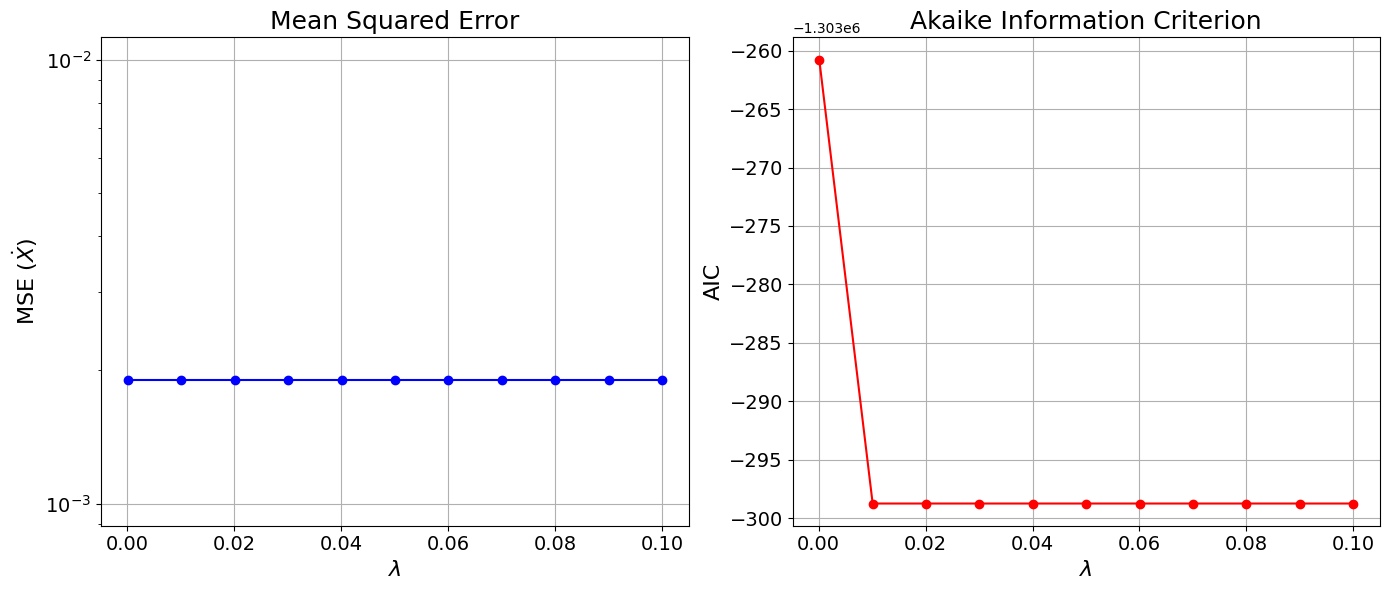

In [49]:
##############################
# Run Threshold search on Light noise model
##############################

threshold_scan = np.linspace(10e-5,10e-2,11)
x_data = np.transpose(np.array([Slight,Ilight]))
coefs = []

for i, threshold in enumerate(threshold_scan):
    model = apply_sindy(Slight, Ilight, t=t, beta=beta, threshold=threshold)
    coefs.append(model.coefficients())
    
plot_pareto(coefs=coefs, model=model, threshold_scan=threshold_scan, x_test=x_data, t_test=t, u=beta)

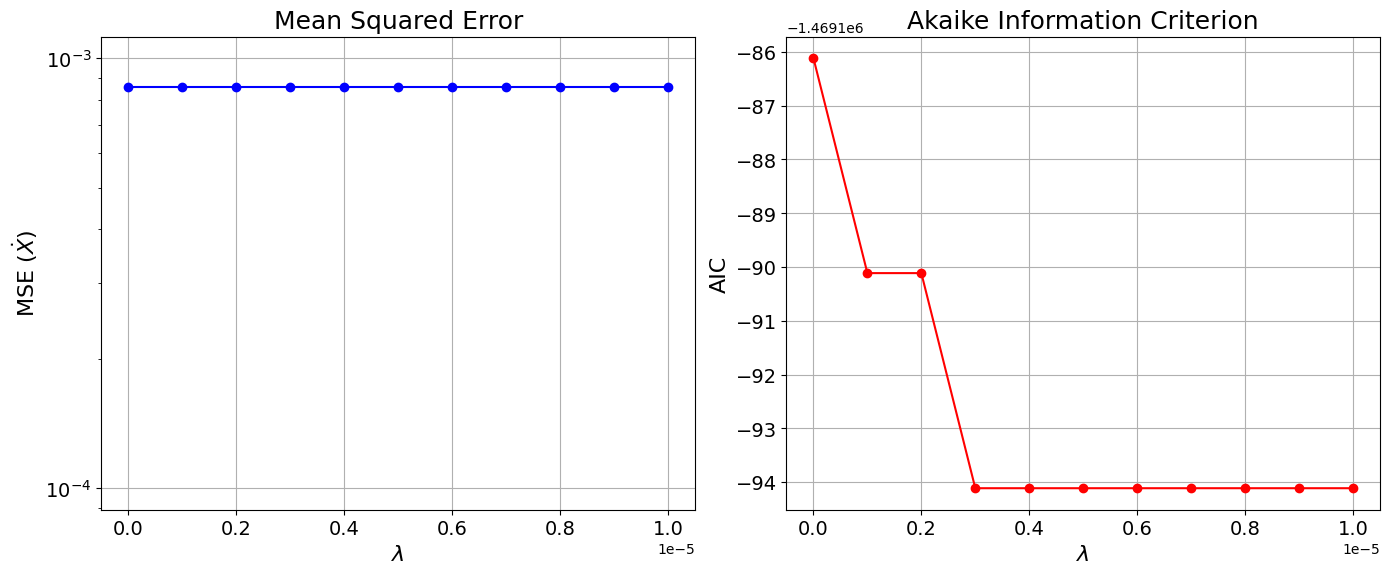

In [48]:
##############################
# Run Threshold search on Med noise model
##############################

threshold_scan = np.linspace(10e-10,10e-6,11)
x_data = np.transpose(np.array([Smed,Imed]))
coefs = []

for i, threshold in enumerate(threshold_scan):
    model = apply_sindy(Smed, Imed, t=t, beta=beta, threshold=threshold)
    coefs.append(model.coefficients())
    
plot_pareto(coefs=coefs, model=model, threshold_scan=threshold_scan, x_test=x_data, t_test=t, u=beta)

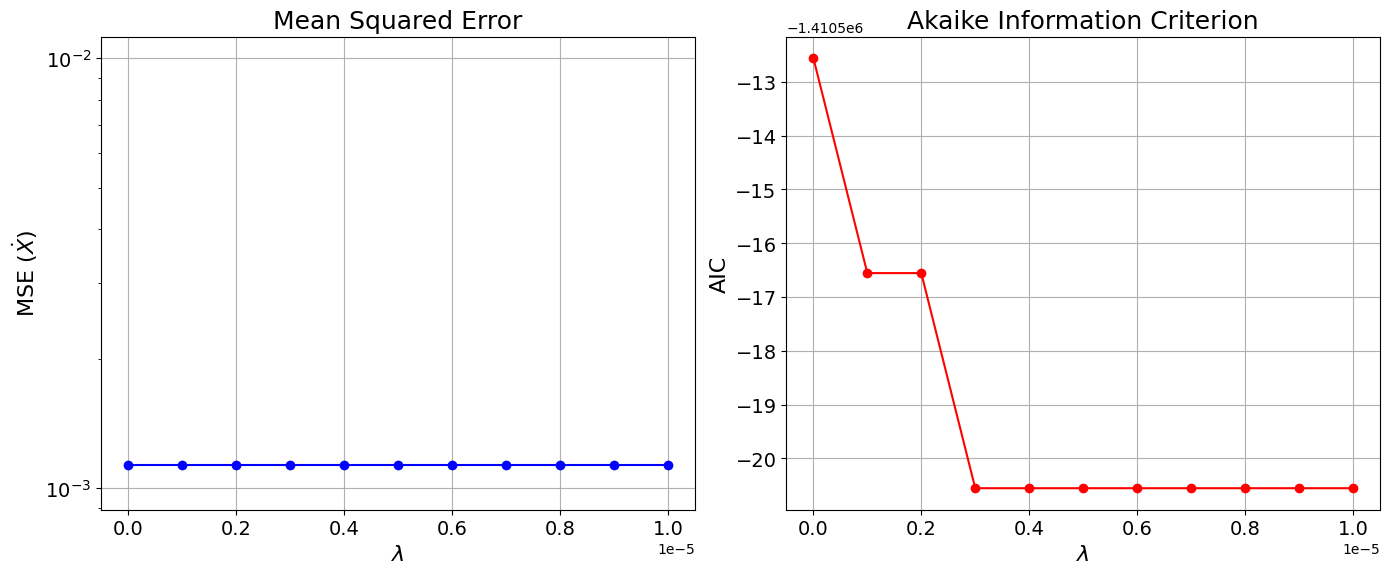

In [47]:
##############################
# Run Threshold search on Heavy noise model
##############################

threshold_scan = np.linspace(10e-10,10e-6,11)
x_data = np.transpose(np.array([Slarge,Ilarge]))
coefs = []

for i, threshold in enumerate(threshold_scan):
    model = apply_sindy(Slarge, Ilarge, t=t, beta=beta, threshold=threshold)
    coefs.append(model.coefficients())
    
plot_pareto(coefs=coefs, model=model, threshold_scan=threshold_scan, x_test=x_data, t_test=t, u=beta)

In [59]:
##############################
# Simulate using SINDy model
##############################

light_noise_model = apply_sindy(Slight, Ilight, t, beta, 10e-10)
med_noise_model = apply_sindy(Smed, Imed, t, beta, 3.0007e-06)
large_noise_model = apply_sindy(Slarge, Ilarge, t, beta, 3.0007e-06)

# init_value = x_data[0]
sim_light = light_noise_model.simulate(init_value, t=len(t), u=beta)
sim_med = med_noise_model.simulate(init_value, t=len(t), u=beta)
sim_large = large_noise_model.simulate(init_value, t=len(t), u=beta)

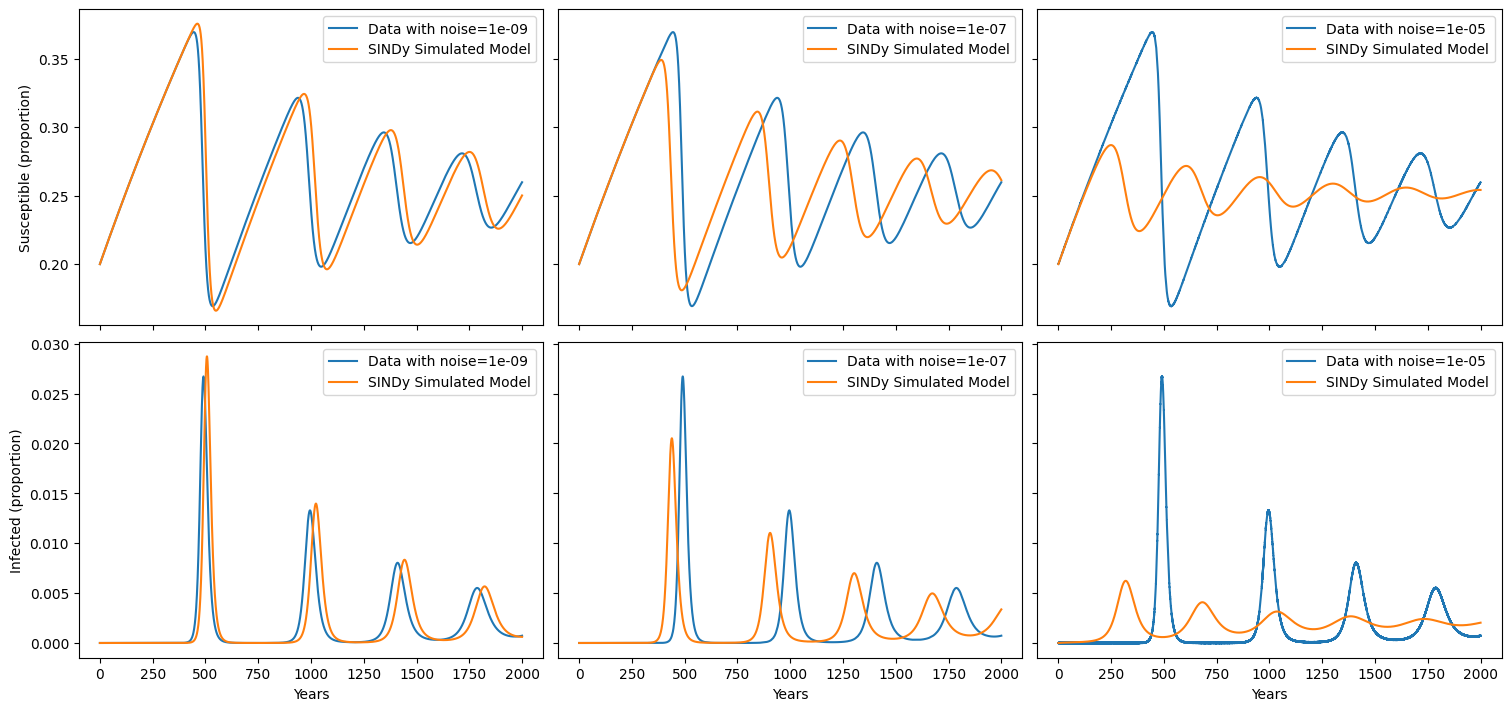

In [60]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 7), sharex='col', sharey='row', layout="constrained")

ax1.plot(t, Slight, label=f"Data with noise={light_noise_value}")
ax1.plot(t, sim_light[:,0], label=f"SINDy Simulated Model")
ax1.set_ylabel('Susceptible (proportion)')
ax1.legend()

ax4.plot(t, Ilight, label=f"Data with noise={light_noise_value}")
ax4.plot(t, sim_light[:,1], label=f"SINDy Simulated Model")
ax4.set_ylabel('Infected (proportion)')
ax4.set_xlabel('Years')
ax4.legend()

ax2.plot(t, Smed, label=f"Data with noise={med_noise_value}")
ax2.plot(t, sim_med[:,0], label=f"SINDy Simulated Model")
ax2.legend()

ax5.plot(t, Imed, label=f"Data with noise={med_noise_value}")
ax5.plot(t, sim_med[:,1], label=f"SINDy Simulated Model")
ax5.set_xlabel('Years')
ax5.legend()

ax3.plot(t, Slarge, label=f"Data with noise={heavy_noise_value}")
ax3.plot(t, sim_large[:,0], label=f"SINDy Simulated Model")
ax3.legend()

ax6.plot(t, Ilarge, label=f"Data with noise={heavy_noise_value}")
ax6.plot(t, sim_large[:,1], label=f"SINDy Simulated Model")
ax6.set_xlabel('Years')
ax6.legend()

plt.show()

#### Print tables of learned coefficients:

In [61]:
def print_table_coefficients(model_to_print, delim="|", latex_ready=False):
    
    model_to_print.get_feature_names()

    if latex_ready:
        delim = " & "

    if latex_ready:
        print("\\begin{tabular}{|c|c|c|}")
        print("\\hline")
        print("Term", delim, "S Eq", delim, "I Eq \\\\")
        print("\\hline")
    else: 
        print("Term", delim, "S Eq", delim, "I Eq")
    
    displayed_feature_names = np.array([])

    for i in range(0,len(model_to_print.get_feature_names())):
        curr_name = model_to_print.get_feature_names()[i]
        if np.isin(curr_name, displayed_feature_names):
            continue
        displayed_feature_names = np.append(displayed_feature_names, curr_name)
        if latex_ready:
            print(curr_name, delim , "{:.10f}".format(model_to_print.coefficients()[0][i]), delim, "{:.10f}".format(model_to_print.coefficients()[1][i]), "\\\\")
        else:
            print(curr_name, delim , "{:.10f}".format(model_to_print.coefficients()[0][i]), delim, "{:.10f}".format(model_to_print.coefficients()[1][i]))
    if latex_ready:
        print("\\hline")
        print("\\end{tabular}")

In [ ]:
print_table_coefficients(light_noise_model, latex_ready=True)
print_table_coefficients(med_noise_model, latex_ready=True)
print_table_coefficients(large_noise_model, latex_ready=True)

\begin{tabular}{|c|c|c|}
\hline
Term  &  S Eq  &  I Eq \\
\hline
1  &  0.0000052675  &  0.0000000000 \\
S  &  0.4998763035  &  -0.0000000000 \\
I  &  0.0000000000  &  0.4979536821 \\
beta  &  0.0000000811  &  0.0000000000 \\
S I  &  -0.0076950944  &  0.0076950944 \\
S beta  &  0.0076941020  &  -0.0000000000 \\
I beta  &  0.0000000000  &  0.0076645090 \\
S I beta  &  -0.0001184430  &  0.0001184430 \\
S^2  &  -0.0000000000  &  0.0000000000 \\
I^2  &  0.0000000002  &  -0.0000000001 \\
beta^2  &  0.0000000012  &  0.0000000000 \\
\hline
\end{tabular}
\begin{tabular}{|c|c|c|}
\hline
Term  &  S Eq  &  I Eq \\
\hline
1  &  0.0000052675  &  0.0000000000 \\
S  &  0.4998763037  &  -0.0000000002 \\
I  &  0.0000000003  &  0.4979536803 \\
beta  &  0.0000000811  &  0.0000000000 \\
S I  &  -0.0076950945  &  0.0076950956 \\
S beta  &  0.0076941020  &  -0.0000000000 \\
I beta  &  0.0000000000  &  0.0076645089 \\
S I beta  &  -0.0001184430  &  0.0001184430 \\
S^2  &  -0.0000000004  &  0.0000000007 \\
I^2

### Model Discovery from Empirical Data

##### Importing Data

In [1]:
##############################
# Load data
# ref: https://github.com/jonathanhorrocks/SINDy-data/tree/master/Horrocks_Repo/data
##############################

import pandas as pd

def load_dataset(disease):
    if disease.lower() == "rubella":
        rubella_data = pd.read_csv('data/OntarioRubellaWeekly39_69.txt', sep="\t", header=None)
        rubella_data.columns = ["week", "cases"]
        rubella_data = rubella_data[(rubella_data["week"] > 1946) & (rubella_data["week"] < 1961)].reset_index() # only take rubella between 1946 and 1961
        # Cleanup Rubella Data (remove NaN):
        # Scrub the NaN rows and create a new rubella_data_nonan set
        rubella_data_nonan = rubella_data.copy()
        rubella_data_nonan["cases"] = rubella_data["cases"].interpolate(method='linear', limit_direction='forward', axis=0)
        rubella_data = rubella_data_nonan

        return rubella_data


    elif disease.lower() == "chickenpox":
        chickenpox_data = pd.read_csv('data/OntarioChickenWeekly39_69.txt', sep="\t", header=None)
        chickenpox_data.columns = ["week", "cases"]
        chickenpox_data = chickenpox_data[(chickenpox_data["week"] > 1946) & (chickenpox_data["week"] < 1967)].reset_index() # only take chickenpox between 1946 and 1967

        return chickenpox_data

    elif disease.lower() == "measles":
        # Imports measles data matrix (stored as .mat file) - ref https://github.com/jonathanhorrocks/SINDy-data/blob/master/Horrocks_Repo/utils/susc_rec/SR_tester.m#L12C1-L13C54
        # Columns: | Time | Cases | Population | Births |
        import scipy.io
        measles_data = pd.DataFrame(scipy.io.loadmat('data/mDataEW_N.mat')["mDataN"])
        measles_data.columns = ["week", "cases", "population", "births"]
        measles_data = measles_data[(measles_data["week"] > 1952) & (measles_data["week"] < 1967)].reset_index() # only take measles data between 1952 and 1967

        return measles_data

    if disease.lower() == "chickenpox_new":
        chickenpox_data = pd.read_csv('data/hungary_chickenpox.csv')
        chickenpox_data.columns = ["Date","BUDAPEST","BARANYA","BACS","BEKES","BORSOD","CSONGRAD","FEJER","GYOR","HAJDU","HEVES","JASZ","KOMAROM","NOGRAD","PEST","SOMOGY","SZABOLCS","TOLNA","VAS","VESZPREM","ZALA"]
        chickenpox_data["Date"] = pd.to_datetime(chickenpox_data['Date'], format='%d/%m/%Y')
        chickenpox_data["week"] = chickenpox_data['Date'].dt.isocalendar().year + (chickenpox_data['Date'].dt.isocalendar().week / 52 - 1/52)
        chickenpox_data["cases"] = np.sum(chickenpox_data.loc[:, chickenpox_data.columns != 'Date'], axis=1)
        chickenpox_data = chickenpox_data[(chickenpox_data["week"] < 2014)].reset_index() # only take chickenpox before and 2014
        # Cleanup Rubella Data (remove NaN):
        # Scrub the NaN rows and create a new rubella_data_nonan set
        chickenpox_data = chickenpox_data.copy()
        chickenpox_data["cases"] = chickenpox_data["cases"].interpolate(method='linear', limit_direction='forward', axis=0)
        # take a smidge off for two values where rounding causes the week to be non monotonically increasing
        curr_val = chickenpox_data.loc[[259]]['week']
        chickenpox_data.at[ 260 , 'week']=curr_val - 0.01
        chickenpox_data.at[ 259 , 'week']=curr_val - 0.011
        #rubella_data = rubella_data_nonan

        return chickenpox_data

    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")

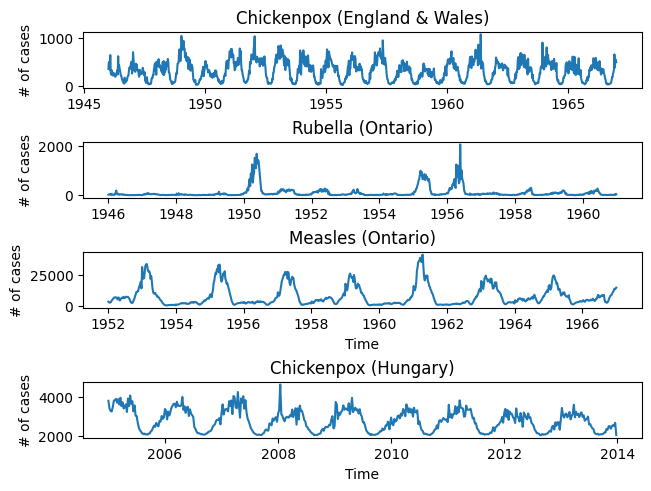

In [4]:
##############################
# Plot data
##############################

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, layout="constrained")

chickenpox_data = load_dataset("chickenpox")
rubella_data = load_dataset("rubella")
measles_data = load_dataset("measles")
hungary_chickenpox = load_dataset("chickenpox_new")

ax1.plot(chickenpox_data["week"],chickenpox_data["cases"])
ax1.set_ylabel('# of cases')
ax1.set_title('Chickenpox (England & Wales)')

ax2.plot(rubella_data["week"],rubella_data["cases"])
ax2.set_ylabel('# of cases')
ax2.set_title('Rubella (Ontario)')

ax3.plot(measles_data["week"],measles_data["cases"])
ax3.set_xlabel('Time')
ax3.set_ylabel('# of cases')
ax3.set_title('Measles (Ontario)')

ax4.plot(hungary_chickenpox["week"],hungary_chickenpox["cases"])
ax4.set_xlabel('Time')
ax4.set_ylabel('# of cases')
ax4.set_title('Chickenpox (Hungary)')

plt.show()

In [5]:
def get_population_and_birth_fit(disease="measles", plt_results=False):

    if disease.lower() == "rubella":

        rubella_data = load_dataset("rubella")

        # Load in demographic / birth rate data for Ontario (for Rubella)
        ontario_demographics = pd.read_csv('data/Ontario_Demographics_Measles.txt', sep="\t", header=None)
        ontario_demographics.columns = ["week", "pop"]

        ontario_birth_data = pd.read_csv('data/Ontario_Birth_Data_M.txt', sep="\t", header=None)
        ontario_birth_data.columns = ["week", "births"]

        # Linear interpolation to fill in missing week's data:
        ontario_population_growth_lin_fit = np.poly1d(np.polyfit(ontario_demographics["week"],ontario_demographics["pop"],1))
        P = ontario_population_growth_lin_fit(rubella_data["week"])

        ontario_birth_data_lin_fit = np.poly1d(np.polyfit(ontario_birth_data["week"],ontario_birth_data["births"],1))
        B = ontario_birth_data_lin_fit(rubella_data["week"])

        if plt_results:
            fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

            ax1.plot(rubella_data["week"], P, '--k', ontario_demographics["week"], ontario_demographics["pop"], 'yo')
            ax1.set_ylabel('Population')
            ax1.set_title('Linear Fit to Ontario Population Growth')

            ax2.plot(rubella_data["week"], B, '--k', ontario_birth_data["week"], ontario_birth_data["births"], 'yo')
            ax2.set_ylabel('Birth Rate')
            ax2.set_title('Linear Fit to Ontario Birth Rate')
            plt.show()
    
    elif disease.lower() == "chickenpox":

        chickenpox_data = load_dataset("chickenpox")

        # Load in demographic / birth rate data for Ontario (for Chickenpox)
        ontario_demographics = pd.read_csv('data/Ontario_Demographics_Measles.txt', sep="\t", header=None)
        ontario_demographics.columns = ["week", "pop"]

        ontario_birth_data = pd.read_csv('data/Ontario_Birth_Data_M.txt', sep="\t", header=None)
        ontario_birth_data.columns = ["week", "births"]

        # Linear interpolation to fill in missing week's data:
        ontario_population_growth_lin_fit = np.poly1d(np.polyfit(ontario_demographics["week"],ontario_demographics["pop"],1))
        P = ontario_population_growth_lin_fit(chickenpox_data["week"])

        ontario_birth_data_lin_fit = np.poly1d(np.polyfit(ontario_birth_data["week"],ontario_birth_data["births"],1))
        B = ontario_birth_data_lin_fit(chickenpox_data["week"])

        if plt_results:
            fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

            ax1.plot(chickenpox_data["week"], P, '--k', ontario_demographics["week"], ontario_demographics["pop"], 'yo')
            ax1.set_ylabel('Population')
            ax1.set_title('Linear Fit to Ontario Population Growth')

            ax2.plot(chickenpox_data["week"], B, '--k', ontario_birth_data["week"], ontario_birth_data["births"], 'yo')
            ax2.set_ylabel('Birth Rate')
            ax2.set_title('Linear Fit to Ontario Birth Rate')
            plt.show()

    elif disease.lower() == "measles":

        measles_data = load_dataset("measles")

        P = measles_data["population"]
        B = measles_data["births"]
        # subset_measles_data = measles_data[(measles_data["week"] > 1952) & (measles_data["week"] < 1967)].reset_index() # only take measles data where birth rate is linear (following Fig 38 of https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-020-63877-w/MediaObjects/41598_2020_63877_MOESM1_ESM.pdf)
        # EW_birth_data_lin_fit = np.poly1d(np.polyfit(subset_measles_data["week"],subset_measles_data["births"],1))
        # B = EW_birth_data_lin_fit(measles_data["week"])
        if plt_results:
            fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

            ax1.plot(measles_data["week"], P, '--k')
            ax1.set_ylabel('Population')
            ax1.set_title('England / Wales Population')

            ax2.plot(measles_data["week"], B, '--k')
            ax2.set_ylabel('Birth Rate')
            ax2.set_title('England / Wales Birth Rate')
            plt.show()

    elif disease.lower() == "chickenpox_new":
        chickenpox_data = load_dataset("chickenpox_new")

        # Load in demographic / birth rate data for Ontario (for Chickenpox)
        hungary_demographics = pd.read_excel('data/hungary_population.xlsx', skiprows=1)
        hungary_demographics = hungary_demographics.rename(columns = {'Unnamed: 0':'week'})
        hungary_demographics["pop"] = np.sum(hungary_demographics.loc[:, hungary_demographics.columns != 'week'], axis=1)

        hungary_birth_data = pd.read_csv('data/hungary_birth_data.txt', sep="\t", header=None)
        hungary_birth_data.columns = ["week", "birthrate"]

        # Linear interpolation to fill in missing week's data:
        hungary_population_growth_lin_fit = np.poly1d(np.polyfit(hungary_demographics["week"],hungary_demographics["pop"],1))
        P = hungary_population_growth_lin_fit(chickenpox_data["week"])

        # d = {
        #     'week': chickenpox_data["week"].values,
        #     'population': P
        # }
        # hungary_demographics_linear = pd.DataFrame(d)

        hungary_birth_data_lin_fit = np.poly1d(np.polyfit(hungary_birth_data["week"],hungary_birth_data["birthrate"],1))
        B = hungary_birth_data_lin_fit(chickenpox_data["week"])
        B = B * P / 1000

        if plt_results:
            fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

            ax1.plot(chickenpox_data["week"], P, '--k', hungary_demographics["week"], hungary_demographics["pop"], 'yo')
            ax1.set_ylabel('Population')
            ax1.set_title('Linear Fit to Hungary Population')

            ax2.plot(chickenpox_data["week"], B, '--k')
            ax2.set_ylabel('Birth Rate')
            ax2.set_title('Linear Fit to Hungary Births')
            plt.show()

    
    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    return P, B

##### Susceptible Reconstruction

Generate "global" Susceptible Estimation:

$$Y_t = -Z_0 + \alpha X_t + R_t + Z_t - U_t$$

In [6]:
####
# Generate _global_ "Susceptible" Estimation for Disease Data
####

def SuscRec_FGglobal(C, B):
    # Input Cases and Birth rate
    # Returns the weighted difference from susceptible mean
    # (Zt-Z0) and the estimated under-reporting rate
    
    Y = np.cumsum(B)
    X = np.cumsum(C)
    P = np.polyfit(X,Y,1)

    alpha = P[1]
    Zt = Y[len(Y)-1] -  alpha*X[len(X)-1]
    return alpha, Zt

In [7]:
####
# Perform Global Susceptible estimation for Disease
####

def generate_global_susceptible(disease = "rubella", plt_results=False):
    if disease.lower() == "rubella":
        dataset = load_dataset("rubella")
        P, B = get_population_and_birth_fit("rubella")

    elif disease.lower() == "chickenpox":
        dataset = load_dataset("chickenpox")
        P, B = get_population_and_birth_fit("chickenpox")

    elif disease.lower() == "measles":
        dataset = load_dataset("measles")
        P, B = get_population_and_birth_fit("measles")
    
    elif disease.lower() == "chickenpox_new":
        dataset = load_dataset("chickenpox_new")
        P, B = get_population_and_birth_fit("chickenpox_new")

    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    S0_p = 0.1  # TODO : Replace this with a value for each disease,
                # corresponding to learned initial value that minimizes model AIC

    cases = dataset["cases"]
    week = dataset["week"]
    N = len(dataset["week"])
    S0 = S0_p * P[0]

    S = np.zeros(N)
    Z = np.zeros(N)
    alpha = np.zeros(N)

    for i in range(1,N):
        Z[i], alpha[i] = SuscRec_FGglobal(cases[:i], B[:i])
        S[i] = S0 + Z[i]

    global_susceptible = np.divide(S, P)
    if plt_results:
        fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

        ax1.plot(week, global_susceptible)
        ax1.set_ylabel('Susceptible Class (prop.)')
        ax1.set_title('Global ' + disease.capitalize() + ' Susceptible Reconstruction')

        plt.show()

    return global_susceptible

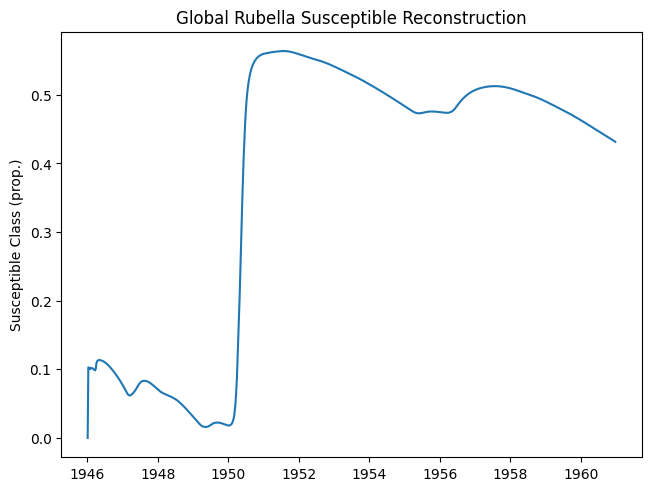

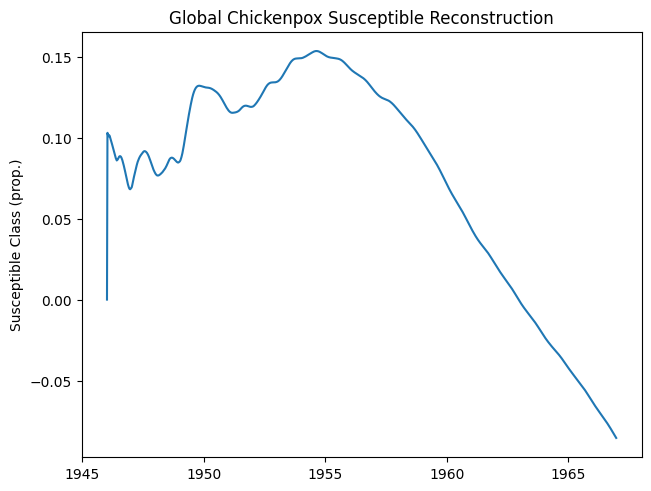

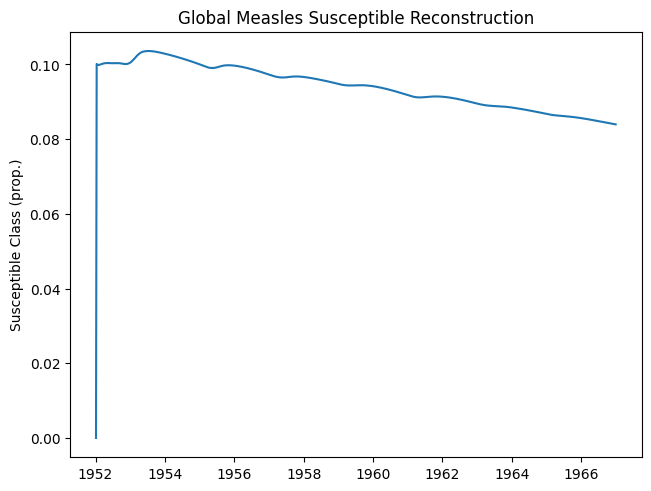

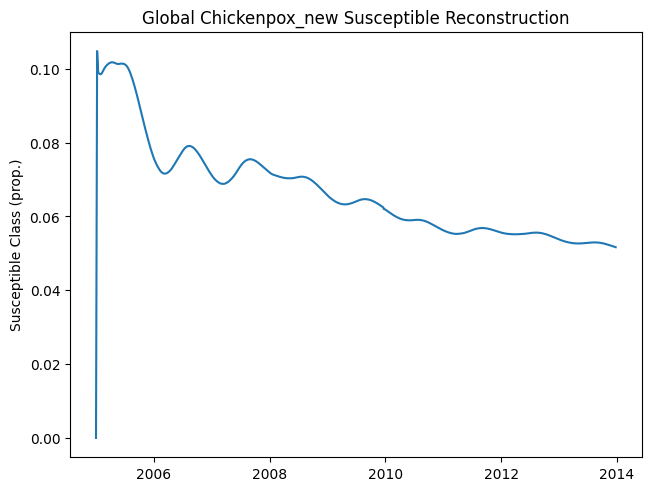

In [76]:
_ = generate_global_susceptible(disease = "rubella", plt_results=True)
_ = generate_global_susceptible(disease = "chickenpox", plt_results=True)
_ = generate_global_susceptible(disease = "measles", plt_results=True)
_ = generate_global_susceptible(disease = "chickenpox_new", plt_results=True)

From `Susceptible Reconstruction` section of the [paper](https://www.nature.com/articles/s41598-020-63877-w.pdf):
$$Y_{t+1} = R_t - U_t Z_0 - (\alpha_{t+1} - \overline{\alpha} ) X_t + \alpha_{t+1} X_{t+1} + Z_{t+1} - u_{t+1}$$

where:
* $Y_t = \displaystyle{\sum_{i=1}^t B_{i-d,i-d+1}}$,
* $R_t = \displaystyle{\sum_{i=1}^t (\alpha_i - \overline{\alpha}) C_i}$,
* $U_t = \displaystyle{\sum_{i=1}^t u_i}$,
* $X_t = \displaystyle{\sum_{i=1}^t C_{i,i+1}}$,
* $B_{t,t+1}$ are the number of new births in week $t$
* $C_{t,t+1}$ are the number of new cases in week $t$
* $Z_t$ is the deviation from the mean Susceptible cases at week $t$, i.e. $S_t = \overline{S} + Z_t$,
* $\alpha_t$ is the rate at which cases are reported at week $t$,
* $u_t$ is the additive noise at week $t$ (assumed to be random Normal - $E(u) = 0, V(u) = \sigma_u^2$)

Code for generating Susceptible data in original paper (in MATLAB) can be found in [this folder](https://github.com/jonathanhorrocks/SINDy-data/tree/master/Horrocks_Repo/utils/susc_rec)


In [8]:
####
# Some helper functions for Gaussian Kernels (used in SuscRec_FGlocal below)
# NOTE / WARNING: This is mostly just a guess at what this is doing; this 
# function isn't actually defined anywhere in the original source code
####

def gauss_kernel(u):
    return np.exp(-0.5 * u ** 2) # / np.sqrt(2 * np.pi)

def gaussKE(h, X, Y):
    N = len(X)
    rHat = np.zeros(N)
    for i in range(N):
        weights = gauss_kernel((X[i] - X) / h) if h != 0 else 0
        weights_sum = np.sum(weights)
        rHat[i] = np.sum(weights * Y) / weights_sum if weights_sum != 0 else 0
    return rHat

####
# Helper Function to Generate _local_ "Susceptible" Estimation 
# See https://github.com/jonathanhorrocks/SINDy-data/blob/master/Horrocks_Repo/utils/susc_rec/SuscRec_FGlocal.m
####

def SuscRec_FGlocal(C, B, fac):
    # Returns the weighted difference from susceptible mean
    # (Zt-Z0) and the estimated under-reporting rate

    Y = np.cumsum(B)
    X = np.cumsum(C)
    rHat = gaussKE(fac * np.std(X), X ,Y)

    alpha = rHat[-1] / X[len(X)-1]
    Zt = Y[len(Y)-1] -  rHat[-1]
    return (Zt, alpha)


In [9]:
####
# Perform Local Susceptible estimation for Disease
####

def generate_local_susceptible(disease = "rubella", plt_results=False):
    if disease.lower() == "rubella":
        dataset = load_dataset("rubella")
        P, B = get_population_and_birth_fit("rubella")
        B_norm = B / (52. / 4.)
        S0_p = 0.1
        # f is the Gaussian kernal's bandwidth parameter
        # this should be chosen to be the value where the SSE 
        # of both the local and global Susceptible estimations intersect
        f = 0.4

    elif disease.lower() == "chickenpox":
        dataset = load_dataset("chickenpox")
        P, B = get_population_and_birth_fit("chickenpox")
        B_norm = B / (52. / 4.)
        S0_p = 0.1
        f = 0.2

    elif disease.lower() == "measles":
        dataset = load_dataset("measles")
        P, B = get_population_and_birth_fit("measles")
        B_norm = B
        S0_p = 0.11286
        f = 0.2

    elif disease.lower() == "chickenpox_new":
        dataset = load_dataset("chickenpox_new")
        P, B = get_population_and_birth_fit("chickenpox_new")
        B_norm = B / (52. / 4.)
        S0_p = 0.1
        f = 0.05

    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")

    cases = dataset["cases"]
    week = dataset["week"]
    N = len(week)
    S0 = S0_p * P[0]
    
    S = np.zeros(N)
    Z = np.zeros(N)
    alpha = np.zeros(N)

    S[0] = S0
    alpha[0] = 8.
    Z[0] = 0.

    for i in range(1,N):
        Z[i], alpha[i] = SuscRec_FGlocal(cases[:i], B_norm[:i], f)
        S[i] = S0 + Z[i]

    local_susceptible = np.divide(S, P)
    # if disease.lower() != "chickenpox_new":
    local_susceptible = savgol_filter(local_susceptible, 5, 2) # smooth Susceptible data, see https://github.com/jonathanhorrocks/SINDy-data/blob/99e927c59f44ca100ffcb15d21c9b0275289025a/Horrocks_Repo/utils/dataSweepSetup.m#L184

    if plt_results:
        fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

        ax1.plot(week, local_susceptible)
        ax1.set_ylabel('Susceptible Class (prop.)')
        ax1.set_title('Local ' + disease.capitalize() + ' Susceptible Reconstruction')

        plt.show()

    return (alpha, local_susceptible, Z)

Matches Figure 40 of [this appendix](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-020-63877-w/MediaObjects/41598_2020_63877_MOESM1_ESM.pdf) (40a is Measles)

#### Incidence to prevalence conversion

Reconstruct the prevalence (infectious) class given incidence data using the conversion:
$$P_t = \frac{C_t p D_i}{\langle C_t \rangle L}$$
where $C_i$ is the temporal case incidence data $D_i = 2$ weeks for all $i$, $L = 65$ years, and $p = 0.95$

In [10]:
###
# Incidence to prevalence conversion
###

def get_incidence_reconstruction(disease = "rubella", plt_results=False):
    if disease.lower() == "rubella":
        dataset = load_dataset("rubella")
    elif disease.lower() == "chickenpox":
        dataset = load_dataset("chickenpox")
    elif disease.lower() == "measles":
        dataset = load_dataset("measles")
    elif disease.lower() == "chickenpox_new":
        dataset = load_dataset("chickenpox_new")
    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    weeks_per_year = 52
    D = 2                   # in weeks
    L = 65 * weeks_per_year # 65 years
    p = 0.95

    C = dataset["cases"].values
    P = C * p * D / (np.mean(C) * L)
    P = savgol_filter(P, 19, 3) # smooth Infectious Rate data, see https://github.com/jonathanhorrocks/SINDy-data/blob/99e927c59f44ca100ffcb15d21c9b0275289025a/Horrocks_Repo/utils/dataSweepSetup.m#L185

    if plt_results:
        fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

        ax1.plot(dataset["week"], P)
        ax1.set_ylabel('Infectious Class (prop.)')
        ax1.set_title('Local ' + disease.capitalize() + ' Infectious Reconstruction')

        plt.show()
    
    return P

#### Transmission rate reconstruction

This appears in Figure 41 in the Appendix [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-020-63877-w/MediaObjects/41598_2020_63877_MOESM1_ESM.pdf)

Use:
$$\beta(t) = \frac{Z_{k+1}}{S_k I_k \Delta t} $$



In [11]:
def transmission_rate_reconstruction(disease = "rubella", plt_results=False):

    if disease.lower() == "rubella":
        dataset = load_dataset("rubella")
        B, P = get_population_and_birth_fit("rubella")
        alpha, susceptible, Z = generate_local_susceptible("rubella", False)
        infectious = get_incidence_reconstruction("rubella", False)

    elif disease.lower() == "chickenpox":
        dataset = load_dataset("chickenpox")
        B, P = get_population_and_birth_fit("chickenpox")
        alpha, susceptible, Z = generate_local_susceptible("chickenpox", False)
        infectious = get_incidence_reconstruction("chickenpox", False)

    elif disease.lower() == "measles":
        dataset = load_dataset("measles")
        B, P = get_population_and_birth_fit("measles")
        alpha, susceptible, Z = generate_local_susceptible("measles", False)
        infectious = get_incidence_reconstruction("measles", False)

    elif disease.lower() == "chickenpox_new":
        dataset = load_dataset("chickenpox_new")
        B, P = get_population_and_birth_fit("chickenpox_new")
        alpha, susceptible, Z = generate_local_susceptible("chickenpox_new", False)
        infectious = get_incidence_reconstruction("chickenpox_new", False)

    else:
        raise RuntimeError("Error: select one disease of (1) Rubella, (2) Chickenpox, or (3) Measles to load data")
    
    N = len(dataset["week"])
    dt = 1. / 52.
    beta = np.zeros(N)

    for i in range(0,N-1):
        beta[i] = Z[i+1] / (susceptible[i] * infectious[i] * float(1))
    beta[N-1] = beta[N-2]
    if disease.lower() == "rubella":
        beta = savgol_filter(beta, 20, 2) # smooth rubella transmission data -- appears particularly noisy
    # for i in range(0,N):
    #     beta[i] = alpha[i] * dataset["cases"].values[i] / (susceptible[i] * infectious[i])
    
    # beta[0] = 0

    # for i in range(0,N-2):
    #     nu = (B[i+1] - B[i]) / dt
    #     mu = nu
    #     beta[i+1] = (susceptible[i] * ( 1 -  mu) - susceptible[i+1] + nu) / (susceptible[i] * infectious[i])

    if plt_results:

        fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, layout="constrained")
        # fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

        ax1.plot(dataset["week"], susceptible)
        ax1.set_ylabel('S Class (prop)')
        ax1.set_title('Local ' + disease.capitalize() + ' Susceptible Reconstruction')
        ax2.plot(dataset["week"], infectious)
        ax2.set_ylabel('I Class (prop.)')
        ax2.set_title(disease.capitalize() + ' Infectious Reconstruction')
        ax3.plot(dataset["week"], beta)
        ax3.set_ylabel('Transmission')
        ax3.set_title(disease.capitalize() + ' Transmission Rate Reconstruction')

        plt.show()

    return susceptible, infectious, beta

#### Displaying all reconstructed data for all diseases

In [12]:
_, _, beta_rubella = transmission_rate_reconstruction("rubella", True)

NameError: name 'savgol_filter' is not defined

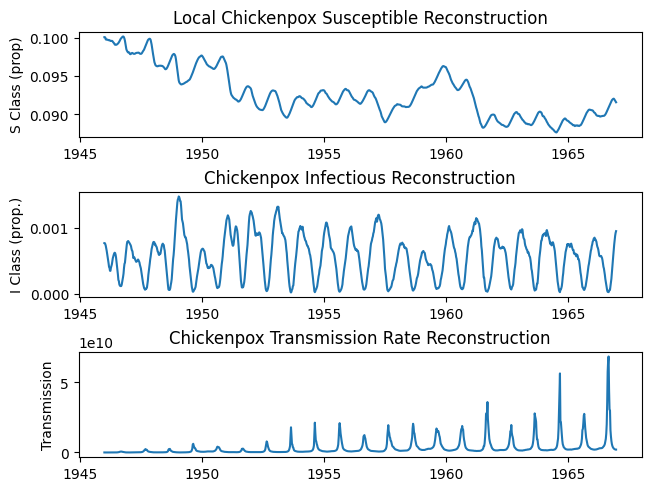

In [ ]:
_, _, beta_chickenpox = transmission_rate_reconstruction("chickenpox", True)

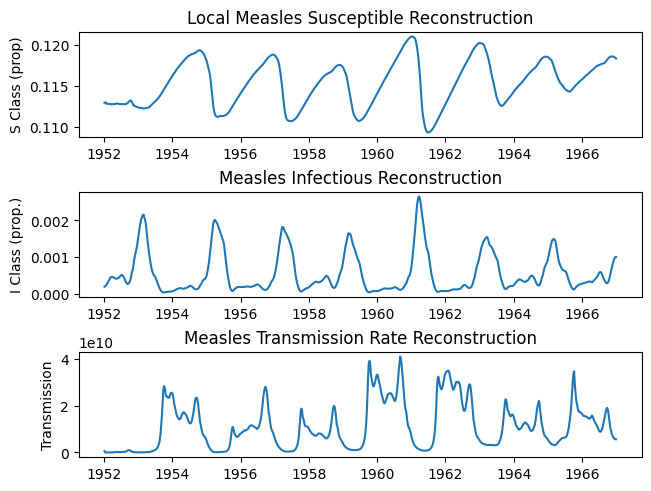

In [ ]:
_, _, beta_measles = transmission_rate_reconstruction("measles", True)

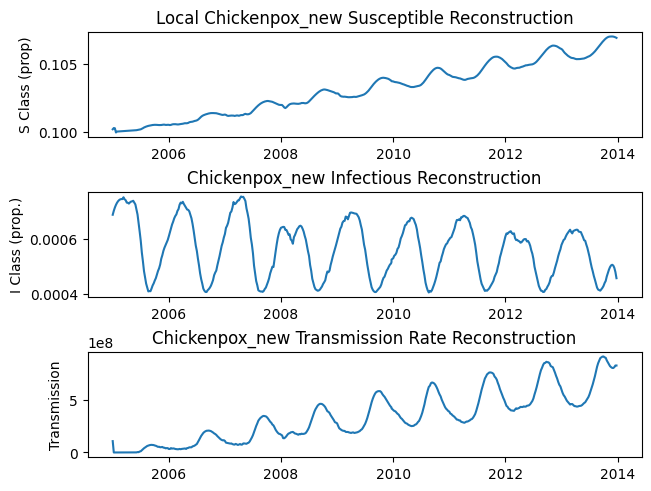

In [ ]:
_, _, beta_hungary_chickenpox = transmission_rate_reconstruction("chickenpox_new", True)

#### Plotting Avg Transmission Rate over course of Calendar Year 

In [19]:
def get_calendar_from_transmission(beta, num_years):
    weeks_per_year = 52
    calendar = np.zeros((weeks_per_year, weeks_per_year * num_years))
    year_index = 0
    for i in range(0, len(beta)):
        calendar[i % weeks_per_year][year_index] = beta[i]
        if (i % weeks_per_year == 0):
            year_index += 1    
    return (np.mean(calendar, axis=1), np.std(calendar, axis=1))

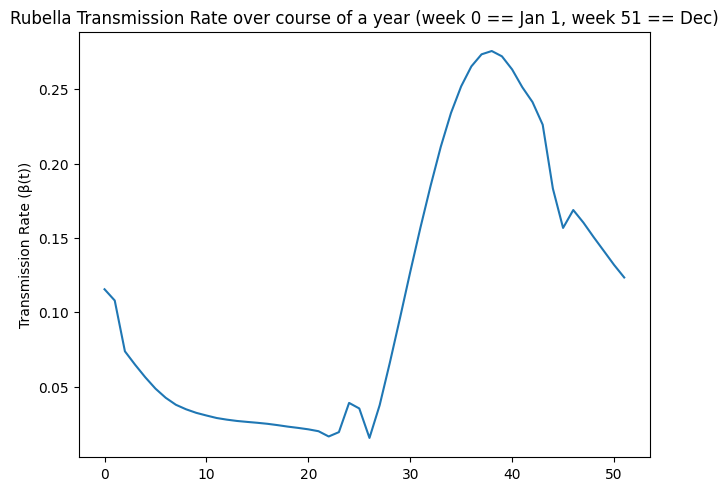

In [103]:
####
# Plot "Transmission Rate" Estimation for Rubella Data
####
dataset = load_dataset("rubella")
num_years = int(dataset["week"].values[-1]) - int(dataset["week"].values[0])
transmission_avg, transmission_std = get_calendar_from_transmission(beta_rubella, num_years)

transmission_avg_norm = transmission_avg / np.linalg.norm(transmission_avg[4:]) 

fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

ax1.errorbar(np.arange(0,52), transmission_avg_norm)
ax1.set_ylabel('Transmission Rate (β(t))')
ax1.set_title('Rubella Transmission Rate over course of a year (week 0 == Jan 1, week 51 == Dec)')

plt.show()

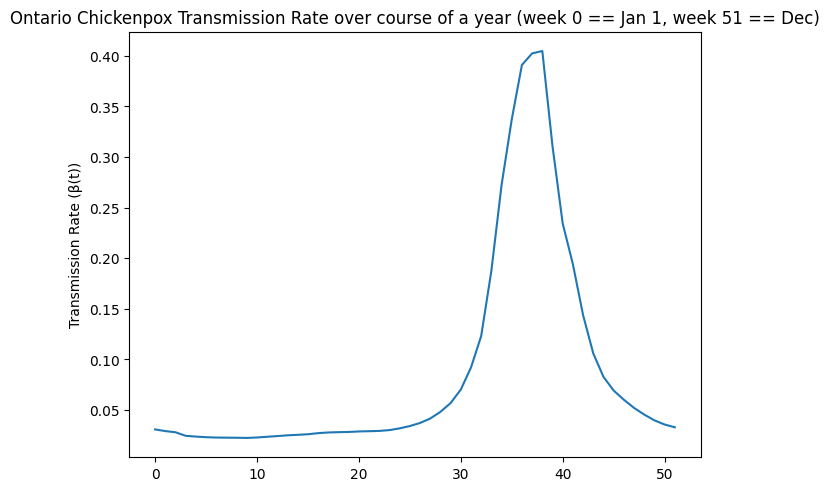

In [91]:
####
# Plot "Transmission Rate" Estimation for New Chickenpox Data
####
dataset = load_dataset("chickenpox")
num_years = int(dataset["week"].values[-1]) - int(dataset["week"].values[0])
transmission_avg, transmission_std = get_calendar_from_transmission(beta_chickenpox, num_years)

transmission_avg_norm = transmission_avg / np.linalg.norm(transmission_avg[4:]) 

fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

ax1.errorbar(np.arange(0,52), transmission_avg_norm)
ax1.set_ylabel('Transmission Rate (β(t))')
ax1.set_title('Ontario Chickenpox Transmission Rate over course of a year (week 0 == Jan 1, week 51 == Dec)')

plt.show()

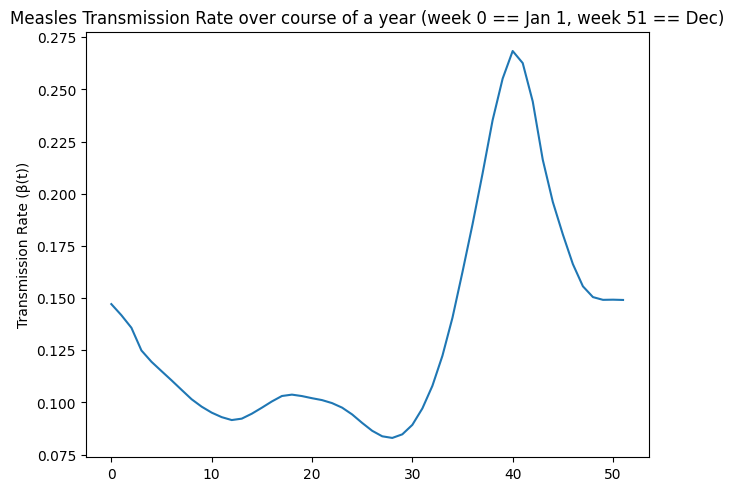

In [92]:
####
# Plot "Transmission Rate" Estimation for New Chickenpox Data
####
dataset = load_dataset("measles")
num_years = int(dataset["week"].values[-1]) - int(dataset["week"].values[0])
transmission_avg, transmission_std = get_calendar_from_transmission(beta_measles, num_years)

transmission_avg_norm = transmission_avg / np.linalg.norm(transmission_avg[4:]) 

fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

ax1.errorbar(np.arange(0,52), transmission_avg_norm)
ax1.set_ylabel('Transmission Rate (β(t))')
ax1.set_title('Measles Transmission Rate over course of a year (week 0 == Jan 1, week 51 == Dec)')

plt.show()

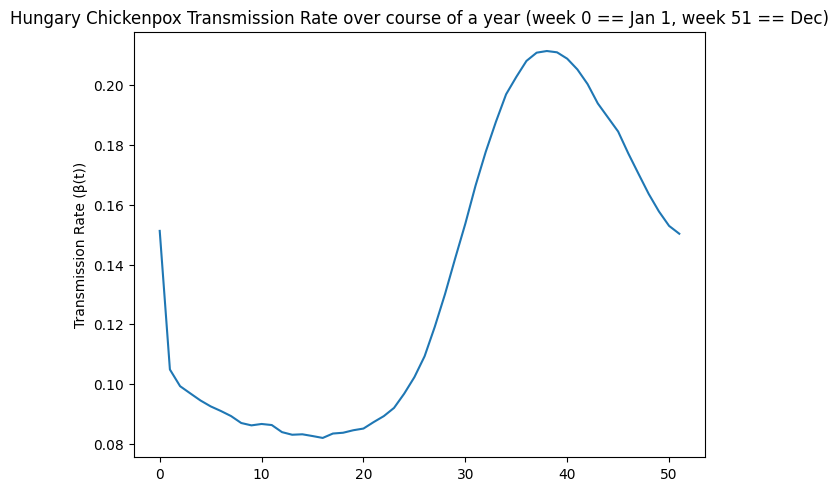

In [ ]:
####
# Plot "Transmission Rate" Estimation for New Chickenpox Data
####
dataset = load_dataset("chickenpox_new")
num_years = int(dataset["week"].values[-1]) - int(dataset["week"].values[0])
transmission_avg, transmission_std = get_calendar_from_transmission(beta, num_years)

transmission_avg_norm = transmission_avg / np.linalg.norm(transmission_avg[4:]) 

fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

ax1.errorbar(np.arange(0,52), transmission_avg_norm)
ax1.set_ylabel('Transmission Rate (β(t))')
ax1.set_title('Hungary Chickenpox Transmission Rate over course of a year (week 0 == Jan 1, week 51 == Dec)')

plt.show()

#### Generate SINDy Model

#### Using Regression by Hand

In [151]:
def simulate_sir_using_sindy_raw(init_s, init_i, xi, theta, beta, time, degree):
    # names= ['1','S','I','SI','S^2','I^2','β','βS','βI','βSI','βS^2','βI^2']
    result_s = np.zeros(time)
    result_i = np.zeros(time)
    result_s[0] = init_s
    result_i[0] = init_i
    phi = np.argmax(beta)
    if degree == 2:
        for i in range(1,time):
            s_t = result_s[i-1]
            i_t = result_i[i-1]
            beta_t = seasonal_cosine(i-1, phi)
            # beta_t = beta[time % 52]
            # beta_t = beta[time - 1]
            st1 = [1, s_t, i_t, s_t * i_t, s_t * s_t, i_t * i_t, beta_t, beta_t * s_t, beta_t * i_t, beta_t * s_t * i_t, beta_t * s_t * s_t, beta_t * i_t * i_t] @ xi[:,0]
            it1 = [1, s_t, i_t, s_t * i_t, s_t * s_t, i_t * i_t, beta_t, beta_t * s_t, beta_t * i_t, beta_t * s_t * i_t, beta_t * s_t * s_t, beta_t * i_t * i_t] @ xi[:,1]
            result_s[i] = min(1,max(0,st1))
            result_i[i] = min(1,max(0,it1))
    else:
        # TODO build polynomial order 3 library
        print("haven't implemented yet")

    return (result_s, result_i)

def prep_for_analysis(disease_name):
    df = load_dataset(disease_name)
    df["population"], df["birth_rate"] = get_population_and_birth_fit(disease_name, False)
    df["susceptible"], df["infectious"], df["beta"] = transmission_rate_reconstruction(disease_name, False)
    df["beta_scaled"] = df["beta"] / np.mean(df["population"])
    return df

def seasonal_cosine(x, phi, beta0 = 0, beta1 = 1, T = 1):
    y = beta0 + beta1 * np.cos(x - phi / 52.)
    return y

def simplified_beta(x, beta0, beta1, T, phi):
    y = beta0 + beta1 * np.cos(T * x - phi)
    return y

def analyze_disease_minimal(df, disease_name, threshold=1e-2, ridge_alpha=1e-6, iterations=2, degree=2):

    t_wk = df["week"]
    t_yr = t_wk / 52.0
    N_series  = df["population"]

    beta_t = df["beta_scaled"]
    s_frac = df["susceptible"]
    I_pre = df["infectious"]
    cases = df["cases"]

    num_years = int(df["week"].values[-1]) - int(df["week"].values[0])
    rate_of_transmission_in_year, transmission_std = get_calendar_from_transmission(beta_t, num_years)
    norm = np.linalg.norm(rate_of_transmission_in_year)
    rate_of_transmission_in_year = rate_of_transmission_in_year / np.linalg.norm(rate_of_transmission_in_year) if norm != 0 else 0
    
    year_in_weeks = np.arange(0,52)

    # T = np.pi * np.argmax(rate_of_transmission_in_year)
    # b = -1 * np.max(rate_of_transmission_in_year)
    # shift = (np.max(rate_of_transmission_in_year) + np.min(rate_of_transmission_in_year) ) / 2
    # A = (np.max(rate_of_transmission_in_year) - np.min(rate_of_transmission_in_year) ) / 2

    # first_approx = [shift, A, T, b]

    # parameters, covariance = curve_fit(simplified_beta, np.arange(0,52), rate_of_transmission_in_year, p0=first_approx)
    # beta0 = parameters[0]
    # beta1 = parameters[1]
    # T = parameters[2]
    # phi = parameters[3]

    # beta_seasonal_fit = simplified_beta(xdata, rate_of_transmission_in_year)

    # PSD
    f_wk, Pxx = welch(cases, fs=1, nperseg=min(1024, len(cases)//2))
    f_yr      = f_wk * 52

    # S_{t+1} and I_{t+1}:
    dS = np.roll(s_frac, -1)
    dI = np.roll(I_pre, -1)
    if degree == 2:
        # build polynomial order 2 library
        ones = np.ones_like(s_frac)
        Θ    = np.column_stack([ones, s_frac, I_pre, s_frac * I_pre, s_frac * s_frac, I_pre * I_pre, beta_t, beta_t * s_frac, beta_t * I_pre, beta_t * s_frac * I_pre, beta_t * s_frac * s_frac, beta_t * I_pre * I_pre])
        names= ['1','S','I','SI','S^2','I^2','β','βS','βI','βSI','βS^2','βI^2']
        for i in range(0,len(names)):
            norm = np.linalg.norm(Θ[:,i])
            Θ[:,i] = Θ[:,i] / norm if norm != 0 else 0
    
    if degree ==3:
        # TODO build polynomial order 3 library
        print("Haven't implemented library yet :(")

    # mask bad rows
    ok   = np.isfinite(Θ).all(1) & np.isfinite(dS) & np.isfinite(dI)
    Θm   = Θ[ok]
    dSm  = dS[ok]
    dIm  = dI[ok]

    # normal equations solve (4×4 invert)
    Dm = np.vstack([dSm, dIm]).T     # (m,2)
    M  = Θm.T @ Θm                   # (12,12)

    # Add ridge regularization to M to handle potential singularity
    M_reg = M + ridge_alpha * np.eye(M.shape[0])
    B  = Θm.T @ Dm                   # (12,2)
    Xi, residuals, rank, s = np.linalg.lstsq(M_reg, B, rcond=None)
        
    
    for i in range(iterations):
        small_indices = np.abs(Xi) < threshold
        Xi[small_indices] = 0.0
        # Regress dynamics for each state variable
        for ind in range(Xi.shape[1]):  # n is the number of state variables
            big_indices = ~small_indices[:, ind]
            if np.any(big_indices):  # Only regress if any terms remain
                Theta_reduced = Θ[:, big_indices]
                dXdt_column = Dm[:, ind]
                Xi[big_indices, ind], _, _, _ = np.linalg.lstsq(Theta_reduced, dXdt_column, rcond=None)

    # pred_S, pred_I = simulate_sir_using_sindy_raw(s_frac[0], I_pre[0], Xi, Θ, rate_of_transmission_in_year, len(t_wk), degree)
    pred_S = Θm @ Xi[:,0]
    pred_I = Θm @ Xi[:,1]


    print(f"\n----- {disease_name.upper()} minimal S–I discovery -----")
    for col, eqn in enumerate(['S_{t+1}','I_{t+1}']):
        terms = [f"{Xi[i,col]:.10f}·{names[i]}" for i in range(len(names)) if Xi[i,col]!=0]
        print(f"{eqn} = " + " + ".join(terms))

    if disease_name == "new_chickenpox":
        disease_name = "Hungarian Chickenpox"

    # plot
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    axs[0].plot(t_yr[ok], s_frac,  '--', label='data')
    axs[0].plot(t_yr[ok], pred_S, '--', label='simulated')
    axs[0].set(title=f"{disease_name} Susceptible Class", xlabel="Years")
    axs[0].legend()

    axs[1].plot(t_yr[ok], I_pre,   label='data')
    axs[1].plot(t_yr[ok], pred_I, '--', label='simulated')
    axs[1].set(title=f"{disease_name} Infectious Class", xlabel="Years")
    axs[1].legend()
    
    # axs[1,0].plot(year_in_weeks, rate_of_transmission_in_year)
    # # axs[1,0].plot(year_in_weeks, beta_seasonal_fit)
    # # axs[1,0].plot(t_yr[ok], beta_t)
    # axs[1,0].set(title=f"{disease_name} β(t)", xlabel="Weeks in Year")
    # # axs[1,0].set(title=f"{disease_name} β(t)", xlabel="Years")

    # axs[1,1].semilogy(f_yr, Pxx)
    # axs[1,1].axvline(1,   ls='--', c='k', label='1 yr⁻¹')
    # axs[1,1].axvline(0.5, ls='--', c='r', label='½ yr⁻¹')
    # axs[1,1].set(title=f"{disease_name} PSD", xlabel="Freq (1/yr)")
    # axs[1,1].legend()

    plt.suptitle(disease_name.capitalize(), fontsize=16)
    plt.tight_layout()
    plt.show()

    return Xi

In [164]:
def analyze_PSD(df, disease_name, threshold=1e-2, ridge_alpha=1e-6, iterations=2, degree=2):

    t_wk = df["week"]
    t_yr = t_wk / 52.0
    N_series  = df["population"]

    beta_t = df["beta_scaled"]
    s_frac = df["susceptible"]
    I_pre = df["infectious"]
    cases = df["cases"]

    num_years = int(df["week"].values[-1]) - int(df["week"].values[0])
    rate_of_transmission_in_year, transmission_std = get_calendar_from_transmission(beta_t, num_years)
    norm = np.linalg.norm(rate_of_transmission_in_year)
    rate_of_transmission_in_year = rate_of_transmission_in_year / np.linalg.norm(rate_of_transmission_in_year) if norm != 0 else 0
    
    year_in_weeks = np.arange(0,52)

    # T = np.pi * np.argmax(rate_of_transmission_in_year)
    # b = -1 * np.max(rate_of_transmission_in_year)
    # shift = (np.max(rate_of_transmission_in_year) + np.min(rate_of_transmission_in_year) ) / 2
    # A = (np.max(rate_of_transmission_in_year) - np.min(rate_of_transmission_in_year) ) / 2

    # first_approx = [shift, A, T, b]

    # parameters, covariance = curve_fit(simplified_beta, np.arange(0,52), rate_of_transmission_in_year, p0=first_approx)
    # beta0 = parameters[0]
    # beta1 = parameters[1]
    # T = parameters[2]
    # phi = parameters[3]

    # beta_seasonal_fit = simplified_beta(xdata, rate_of_transmission_in_year)

    # PSD
    f_wk, Pxx = welch(cases, fs=1, nperseg=min(1024, len(cases)//2))
    f_yr      = f_wk * 52

    # S_{t+1} and I_{t+1}:
    dS = np.roll(s_frac, -1)
    dI = np.roll(I_pre, -1)
    if degree == 2:
        # build polynomial order 2 library
        ones = np.ones_like(s_frac)
        Θ    = np.column_stack([ones, s_frac, I_pre, s_frac * I_pre, s_frac * s_frac, I_pre * I_pre, beta_t, beta_t * s_frac, beta_t * I_pre, beta_t * s_frac * I_pre, beta_t * s_frac * s_frac, beta_t * I_pre * I_pre])
        names= ['1','S','I','SI','S^2','I^2','β','βS','βI','βSI','βS^2','βI^2']
        for i in range(0,len(names)):
            norm = np.linalg.norm(Θ[:,i])
            Θ[:,i] = Θ[:,i] / norm if norm != 0 else 0
    
    if degree ==3:
        # TODO build polynomial order 3 library
        print("Haven't implemented library yet :(")

    # mask bad rows
    ok   = np.isfinite(Θ).all(1) & np.isfinite(dS) & np.isfinite(dI)
    Θm   = Θ[ok]
    dSm  = dS[ok]
    dIm  = dI[ok]

    # normal equations solve (4×4 invert)
    Dm = np.vstack([dSm, dIm]).T     # (m,2)
    M  = Θm.T @ Θm                   # (12,12)

    # Add ridge regularization to M to handle potential singularity
    M_reg = M + ridge_alpha * np.eye(M.shape[0])
    B  = Θm.T @ Dm                   # (12,2)
    Xi, residuals, rank, s = np.linalg.lstsq(M_reg, B, rcond=None)
        
    
    for i in range(iterations):
        small_indices = np.abs(Xi) < threshold
        Xi[small_indices] = 0.0
        # Regress dynamics for each state variable
        for ind in range(Xi.shape[1]):  # n is the number of state variables
            big_indices = ~small_indices[:, ind]
            if np.any(big_indices):  # Only regress if any terms remain
                Theta_reduced = Θ[:, big_indices]
                dXdt_column = Dm[:, ind]
                Xi[big_indices, ind], _, _, _ = np.linalg.lstsq(Theta_reduced, dXdt_column, rcond=None)

    # pred_S, pred_I = simulate_sir_using_sindy_raw(s_frac[0], I_pre[0], Xi, Θ, rate_of_transmission_in_year, len(t_wk), degree)
    pred_S = Θm @ Xi[:,0]
    pred_I = Θm @ Xi[:,1]


    print(f"\n----- {disease_name.upper()} minimal S–I discovery -----")
    for col, eqn in enumerate(['S_{t+1}','I_{t+1}']):
        terms = [f"{Xi[i,col]:.10f}·{names[i]}" for i in range(len(names)) if Xi[i,col]!=0]
        print(f"{eqn} = " + " + ".join(terms))

    if disease_name == "new_chickenpox":
        disease_name = "Hungarian Chickenpox"

    # plot
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    # axs[0,0].plot(t_yr[ok], s_frac,  '--', label='data')
    # axs[0,0].plot(t_yr[ok], pred_S, '--', label='simulated')
    # axs[0,0].set(title=f"{disease_name} Susceptible Class", xlabel="Years")
    # axs[0,0].legend()

    # axs[1,0].plot(t_yr[ok], I_pre,   label='data')
    # axs[1,0].plot(t_yr[ok], pred_I, '--', label='simulated')
    # axs[1,0].set(title=f"{disease_name} Infectious Class", xlabel="Years")
    # axs[1,0].legend()

    # PSD
    f_wk, susc_psd = welch(s_frac, fs=1, nperseg=min(1024, len(s_frac)//2))
    f_wk, s_pred_psd = welch(pred_S, fs=1, nperseg=min(1024, len(pred_S)//2))
    f_yr      = f_wk * 52

    axs[0].semilogy(f_yr, susc_psd, label="Susc")
    axs[0].semilogy(f_yr, s_pred_psd, label="Susc Pred")
    axs[0].axvline(1,   ls='--', c='k', label='1 yr⁻¹')
    axs[0].axvline(0.5, ls='--', c='r', label='½ yr⁻¹')
    axs[0].set(title=f"{disease_name} Susceptible PSD", xlabel="Freq (1/yr)")
    axs[0].legend()

    f_wk, inf_psd = welch(I_pre, fs=1, nperseg=min(1024, len(I_pre)//2))
    f_wk, i_pred_psd = welch(pred_I, fs=1, nperseg=min(1024, len(pred_I)//2))
    f_yr      = f_wk * 52

    axs[1].semilogy(f_yr, inf_psd, label="Inf")
    axs[1].semilogy(f_yr, i_pred_psd, label="Inf Pred")
    axs[1].axvline(1,   ls='--', c='k', label='1 yr⁻¹')
    axs[1].axvline(0.5, ls='--', c='r', label='½ yr⁻¹')
    axs[1].set(title=f"{disease_name} Infected PSD", xlabel="Freq (1/yr)")
    axs[1].legend()

    plt.suptitle(disease_name.capitalize() + " Power Spectral Decomposition", fontsize=16)
    plt.tight_layout()
    plt.show()

    return Xi

In [20]:
measles_data = prep_for_analysis("measles")
rubella_data = prep_for_analysis("rubella")
chickenpox_data = prep_for_analysis("chickenpox")
hungarian_chickenpox_data = prep_for_analysis("chickenpox_new")

In [212]:
hungarian_chickenpox_data.head(5)

,index,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,...,VESZPREM,ZALA,week,cases,population,birth_rate,susceptible,infectious,beta,beta_scaled
0,0,2005-01-03,168,79,30,173,169,42,136,120,...,87,68,2005.0,3812.0,1.009276e+07,96413.343348,0.100000,0.000687,1.079884e+08,10.836314
1,1,2005-01-10,157,60,30,92,200,53,51,70,...,68,26,2005.019231,3412.019231,1.009221e+07,96398.960148,0.100740,0.000701,0.000000e+00,0.000000
2,2,2005-01-17,96,44,31,86,93,30,93,84,...,62,44,2005.038462,3289.038462,1.009167e+07,96384.577939,0.100011,0.000713,0.000000e+00,0.000000
3,3,2005-01-24,163,49,43,126,46,39,52,114,...,43,31,2005.057692,3260.057692,1.009112e+07,96370.196722,0.100016,0.000723,0.000000e+00,0.000000
4,4,2005-01-31,122,78,53,87,103,34,95,131,...,85,60,2005.076923,3483.076923,1.009057e+07,96355.816495,0.100022,0.000730,0.000000e+00,0.000000



----- RUBELLA minimal S–I discovery -----
S_{t+1} = -0.1274445074·1 + 3.1425436136·S + -0.1443241725·S^2 + -0.4073146593·β + 0.8751143510·βS + -0.4672856616·βS^2
I_{t+1} = 0.0996127363·S + -0.0846884962·S^2


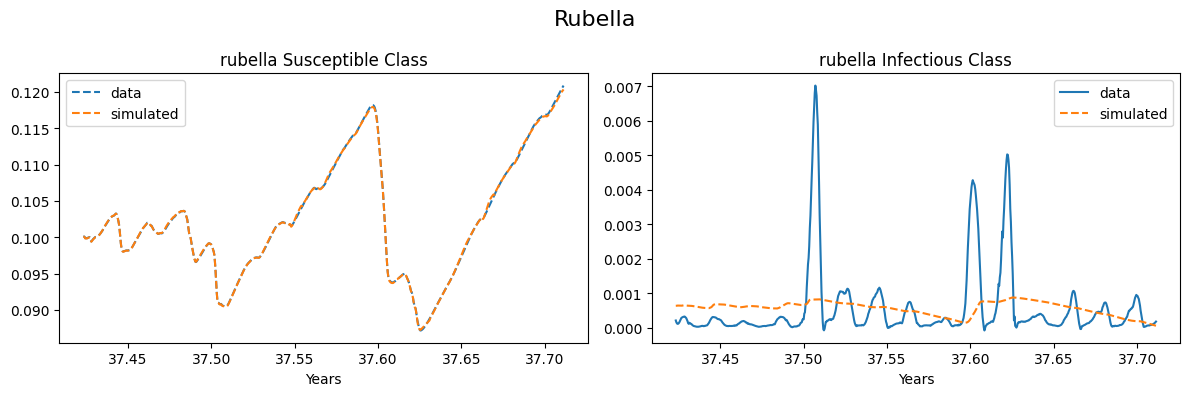

In [152]:
_ = analyze_disease_minimal(rubella_data, "rubella", threshold=0.03, ridge_alpha=0, iterations=100)


----- RUBELLA minimal S–I discovery -----
S_{t+1} = -0.1274445074·1 + 3.1425436136·S + -0.1443241725·S^2 + -0.4073146593·β + 0.8751143510·βS + -0.4672856616·βS^2
I_{t+1} = 0.0996127363·S + -0.0846884962·S^2


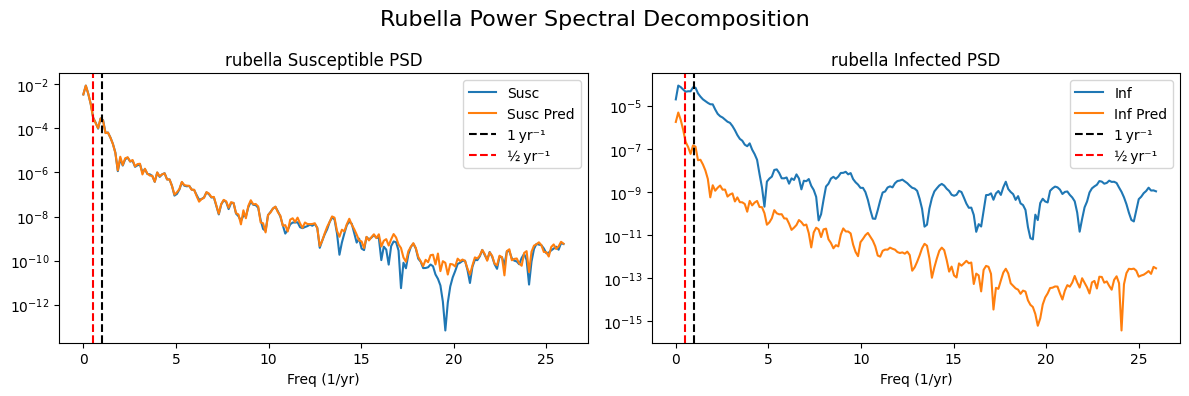

In [165]:
_ = analyze_PSD(rubella_data, "rubella", threshold=0.03, ridge_alpha=0, iterations=100)


----- MEASLES minimal S–I discovery -----
S_{t+1} = 0.3351548463·1 + 2.6820294786·S + 0.2057054345·S^2 + -1.6092492213·β + 3.2061489566·βS + -0.1172326775·βI + 0.1169016425·βSI + -1.5913640174·βS^2
I_{t+1} = -0.0641210803·1 + 0.0920775319·S + 1.8201687981·β + -3.6290524989·βS + 1.7935348201·βS^2


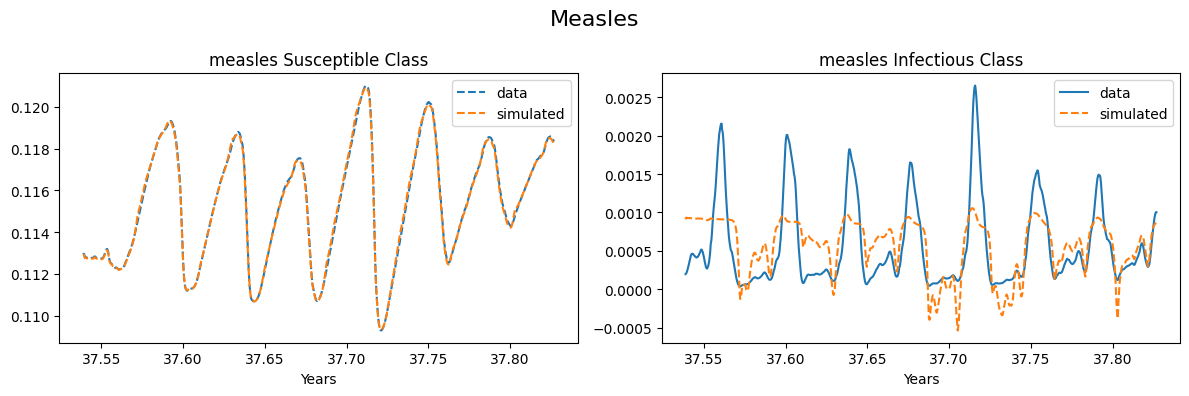

In [153]:
_ = analyze_disease_minimal(measles_data, "measles", threshold=0.05, ridge_alpha=0., iterations=100)


----- MEASLES minimal S–I discovery -----
S_{t+1} = 0.3351548463·1 + 2.6820294786·S + 0.2057054345·S^2 + -1.6092492213·β + 3.2061489566·βS + -0.1172326775·βI + 0.1169016425·βSI + -1.5913640174·βS^2
I_{t+1} = -0.0641210803·1 + 0.0920775319·S + 1.8201687981·β + -3.6290524989·βS + 1.7935348201·βS^2


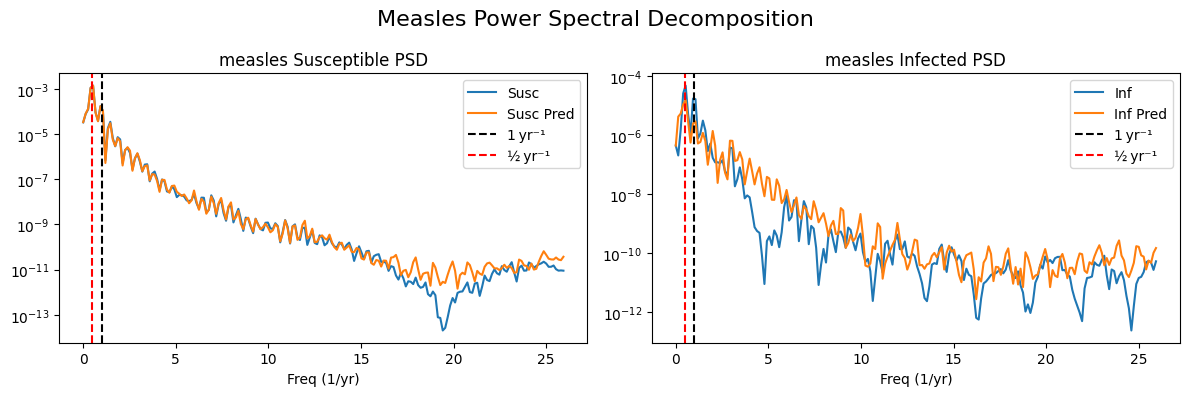

In [166]:
_ = analyze_PSD(measles_data, "measles", threshold=0.05, ridge_alpha=0., iterations=100)


----- CHICKENPOX minimal S–I discovery -----
S_{t+1} = -0.7173571801·1 + 4.4679708632·S + -0.6826857077·S^2 + 1.1288234010·β + -2.2789780563·βS + 0.0563803330·βI + -0.0552823640·βSI + 1.1524328772·βS^2
I_{t+1} = -2.0094565235·1 + 4.0449550222·S + -2.0153537416·S^2 + -2.4537359968·β + 4.9872430886·βS + -2.5414981379·βS^2


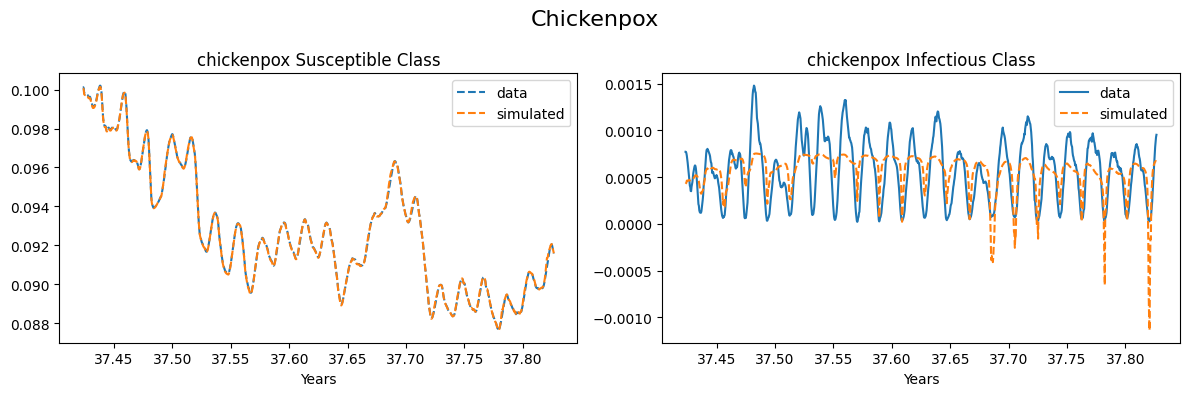

In [154]:
_ = analyze_disease_minimal(chickenpox_data, "chickenpox", threshold=0.03, ridge_alpha=0., iterations=1000)


----- CHICKENPOX minimal S–I discovery -----
S_{t+1} = -0.7173571801·1 + 4.4679708632·S + -0.6826857077·S^2 + 1.1288234010·β + -2.2789780563·βS + 0.0563803330·βI + -0.0552823640·βSI + 1.1524328772·βS^2
I_{t+1} = -2.0094565235·1 + 4.0449550222·S + -2.0153537416·S^2 + -2.4537359968·β + 4.9872430886·βS + -2.5414981379·βS^2


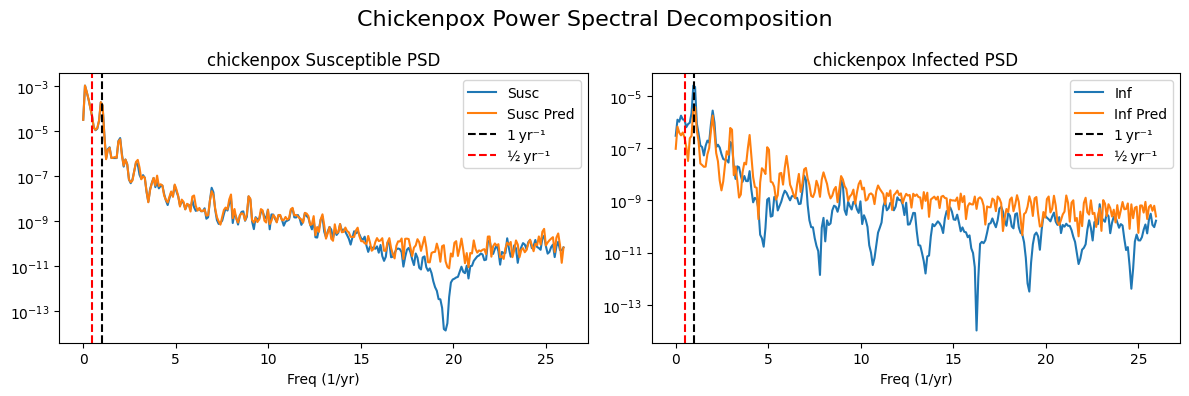

In [167]:
_ = analyze_PSD(chickenpox_data, "chickenpox", threshold=0.03, ridge_alpha=0., iterations=1000)


----- NEW_CHICKENPOX minimal S–I discovery -----
S_{t+1} = -29.8089157757·1 + 64.1176495066·S + -0.8823066408·I + 0.8999736125·SI + -32.1295431810·S^2 + -6.6932098730·β + 13.6125838022·βS + -1.2766391473·βI + 1.2963059920·βSI + -6.9038313261·βS^2
I_{t+1} = 0.4515749490·1 + -0.8358334560·S + 0.3965648636·S^2


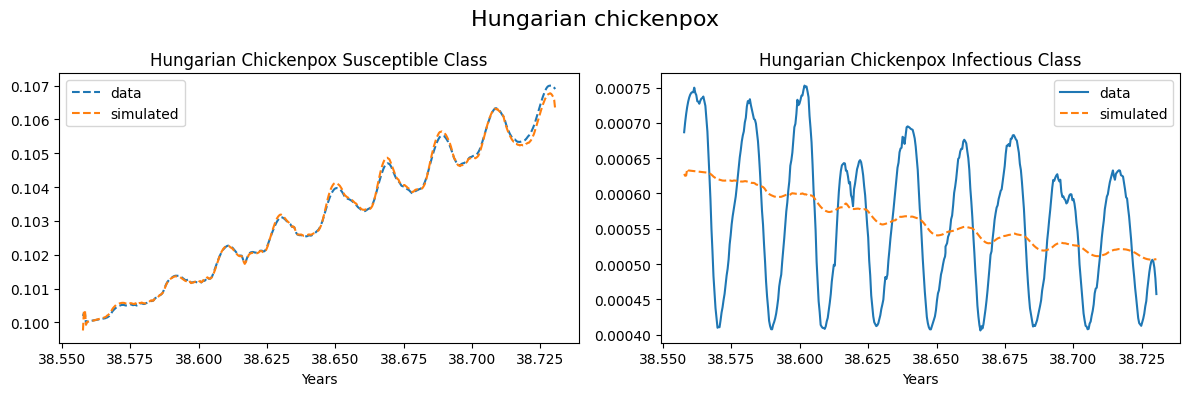

In [156]:
_ = analyze_disease_minimal(hungarian_chickenpox_data, "new_chickenpox", threshold=0.3, ridge_alpha=0., iterations=5)


----- NEW_CHICKENPOX minimal S–I discovery -----
S_{t+1} = -29.8089157757·1 + 64.1176495066·S + -0.8823066408·I + 0.8999736125·SI + -32.1295431810·S^2 + -6.6932098730·β + 13.6125838022·βS + -1.2766391473·βI + 1.2963059920·βSI + -6.9038313261·βS^2
I_{t+1} = 0.4515749490·1 + -0.8358334560·S + 0.3965648636·S^2


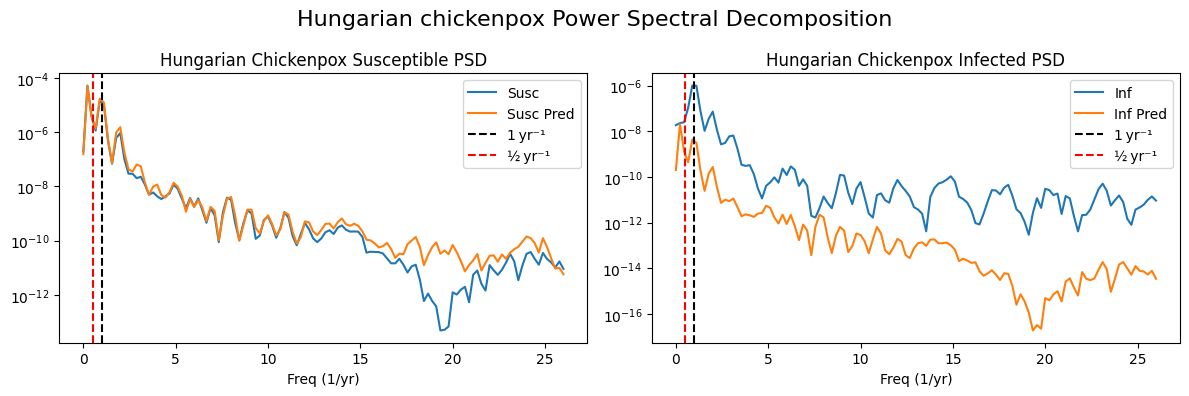

In [168]:
_ = analyze_PSD(hungarian_chickenpox_data, "new_chickenpox", threshold=0.3, ridge_alpha=0., iterations=5)

#### Using PySINDy

In [ ]:
def build_sindy(susceptible, infectious, beta, t, degree=2, threshold=10e-4):
    disease_si = np.transpose(np.array([susceptible, infectious]))
    init_value = np.transpose(np.array([susceptible[0], infectious[0]]))

    feature_library = ps.PolynomialLibrary(degree=degree)
    optimizer = ps.STLSQ(threshold=threshold)

    disease_model = ps.SINDy(
        feature_library=feature_library,
        optimizer=optimizer,
        feature_names=["S","I","beta"],
        discrete_time=True
    )

    disease_model.fit(disease_si, t=t, u=beta)
    return (disease_model, init_value)

In [122]:
measles_data

,index,week,cases,population,births,birth_rate,susceptible,infectious,beta,beta_scaled
0,208,1952.0137,3445.0,4.152291e+07,12924.448157,12924.448157,0.112940,0.000198,5.789381e+08,1.333774e+01
1,209,1952.0329,2846.0,4.152778e+07,12928.365119,12928.365119,0.112962,0.000206,0.000000e+00,0.000000e+00
2,210,1952.0521,2771.0,4.153266e+07,12932.282081,12932.282081,0.112940,0.000222,6.107212e+00,1.406996e-07
3,211,1952.0712,2846.0,4.153750e+07,12936.178642,12936.178642,0.112794,0.000246,1.711857e+04,3.943824e-04
4,212,1952.0904,3370.0,4.154238e+07,12940.095604,12940.095604,0.112807,0.000274,1.075062e+05,2.476756e-03
...,...,...,...,...,...,...,...,...,...,...
778,986,1966.9205,12177.0,4.521734e+07,15987.109522,15987.109522,0.118552,0.000889,6.384989e+09,1.470991e+02
779,987,1966.9397,13812.0,4.522193e+07,15980.606784,15980.606784,0.118512,0.000942,6.012595e+09,1.385198e+02
780,988,1966.9589,13522.0,4.522652e+07,15974.104045,15974.104045,0.118458,0.000980,5.762858e+09,1.327663e+02
781,989,1966.9781,13892.0,4.523110e+07,15967.601306,15967.601306,0.118400,0.001001,5.623546e+09,1.295568e+02


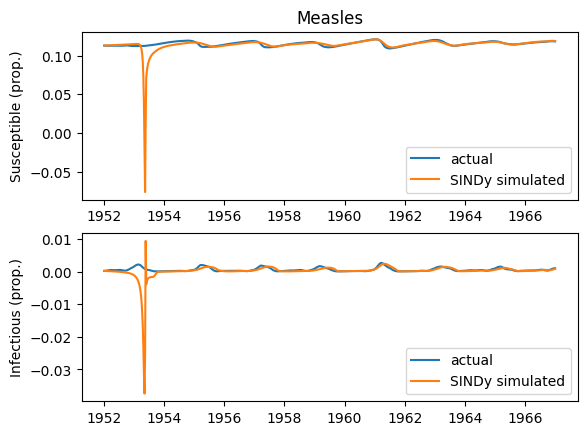

In [135]:
measles_model, init_value = build_sindy(measles_data["susceptible"], measles_data["infectious"], measles_data["beta_scaled"], measles_data["week"].values, 2, 10e-4)
sim = measles_model.simulate(init_value, t=len(measles_data["week"]), u=measles_data["beta_scaled"])

fig, ((ax1, ax2)) = plt.subplots(2, 1)

ax1.plot(measles_data["week"], measles_data["susceptible"], label="actual")
ax1.plot(measles_data["week"], sim[:,0], label="SINDy simulated")
ax1.set_ylabel('Susceptible (prop.)')
ax1.legend()

ax2.plot(measles_data["week"], measles_data["infectious"], label="actual")
ax2.plot(measles_data["week"], sim[:,1], label="SINDy simulated")
ax2.set_ylabel('Infectious (prop.)')
ax2.legend()

ax1.set_title('Measles')

plt.show()

In [865]:
measles_model.print()

(S)[k+1] = 0.111 1 + 0.012 S[k] + 0.001 S[k]^2
(I)[k+1] = -0.008 S[k] + -0.136 I[k] + 0.076 S[k]^2 + 9.907 S[k] I[k] + 0.185 I[k]^2


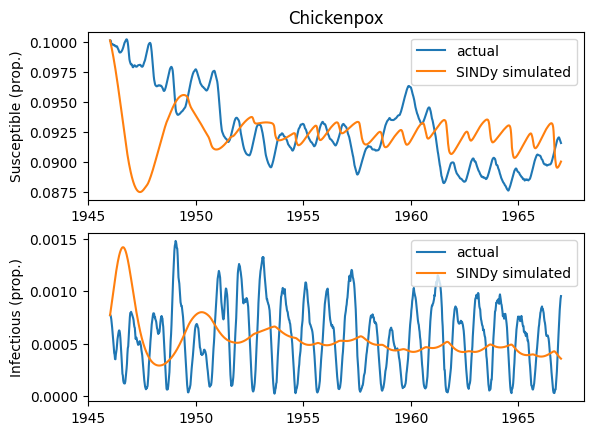

In [869]:
chickenpox_model, init_value = build_sindy(chickenpox_data["susceptible"], chickenpox_data["infectious"], chickenpox_data["beta_scaled"], chickenpox_data["week"].values, 2, 10e-4)
sim = chickenpox_model.simulate(init_value, t=len(chickenpox_data["week"]), u=chickenpox_data["beta_scaled"])

fig, ((ax1, ax2)) = plt.subplots(2, 1)

ax1.plot(chickenpox_data["week"], chickenpox_data["susceptible"], label="actual")
ax1.plot(chickenpox_data["week"], sim[:,0], label="SINDy simulated")
ax1.set_ylabel('Susceptible (prop.)')
ax1.legend()

ax2.plot(chickenpox_data["week"], chickenpox_data["infectious"], label="actual")
ax2.plot(chickenpox_data["week"], sim[:,1], label="SINDy simulated")
ax2.set_ylabel('Infectious (prop.)')
ax2.legend()

ax1.set_title('Chickenpox')

plt.show()

In [712]:
chickenpox_model.print()

(S)[k+1] = -0.012 1 + 1.260 S[k] + -0.300 I[k] + -1.423 S[k]^2 + -0.006 S[k] I[k] + 0.001 I[k]^2
(I)[k+1] = 0.000


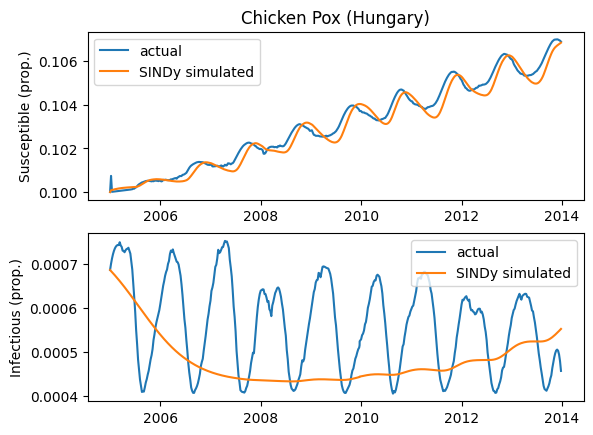

In [214]:
hungarian_chickenpox_model, init_value = build_sindy(hungarian_chickenpox_data["susceptible"], hungarian_chickenpox_data["infectious"], hungarian_chickenpox_data["beta"], np.array(hungarian_chickenpox_data["week"]), 2, 10e-4)
sim = hungarian_chickenpox_model.simulate(init_value, t=len(hungarian_chickenpox_data["week"]), u=hungarian_chickenpox_data["beta"])

fig, ((ax1, ax2)) = plt.subplots(2, 1)

ax1.plot(hungarian_chickenpox_data["week"], hungarian_chickenpox_data["susceptible"], label="actual")
ax1.plot(hungarian_chickenpox_data["week"], sim[:,0], label="SINDy simulated")
ax1.set_ylabel('Susceptible (prop.)')
ax1.legend()

ax2.plot(hungarian_chickenpox_data["week"], hungarian_chickenpox_data["infectious"], label="actual")
ax2.plot(hungarian_chickenpox_data["week"], sim[:,1], label="SINDy simulated")
ax2.set_ylabel('Infectious (prop.)')
ax2.legend()

ax1.set_title('Chicken Pox (Hungary)')

plt.show()

In [197]:
hungarian_chickenpox_model.print()

(S)[k+1] = 0.011 1 + 0.876 S[k] + -0.046 I[k] + 0.178 S[k]^2 + -0.004 S[k] I[k] + 0.027 S[k]^3
(I)[k+1] = -0.133 1 + 3.904 S[k] + -6.444 I[k] + -38.022 S[k]^2 + 71.410 S[k] I[k] + 6731.578 I[k]^2 + 122.916 S[k]^3 + -58.411 S[k]^2 I[k] + -53770.875 S[k] I[k]^2 + -664828.348 I[k]^3


In [ ]:
measles_model, init_value = build_sindy(measles_data["susceptible"], measles_data["infectious"], measles_data["beta"], measles_data["week"].values, 2, 10e-4)
sim = measles_model.simulate(init_value, t=len(measles_data["week"]), u=measles_data["beta"])

fig, ((ax1, ax2)) = plt.subplots(2, 1)

ax1.plot(dataset["week"], susceptible, label="actual")
ax1.plot(dataset["week"], sim[:,0], label="SINDy simulated")
ax1.set_ylabel('Susceptible (prop.)')
ax1.legend()

ax2.plot(dataset["week"], infectious, label="actual")
ax2.plot(dataset["week"], sim[:,1], label="SINDy simulated")
ax2.set_ylabel('Infectious (prop.)')
ax2.legend()

ax1.set_title('Measles')

plt.show()

#### Info for extension

Data from https://archive.ics.uci.edu/dataset/580/hungarian+chickenpox+cases

In [21]:
##############################
# Load data
# ref: https://github.com/jonathanhorrocks/SINDy-data/tree/master/Horrocks_Repo/data
##############################

import pandas as pd
import numpy as np

def load_new_dataset(disease):
    if disease.lower() == "chickenpox":
        chickenpox_data = pd.read_csv('data/hungary_chickenpox.csv')
        chickenpox_data.columns = ["Date","BUDAPEST","BARANYA","BACS","BEKES","BORSOD","CSONGRAD","FEJER","GYOR","HAJDU","HEVES","JASZ","KOMAROM","NOGRAD","PEST","SOMOGY","SZABOLCS","TOLNA","VAS","VESZPREM","ZALA"]
        chickenpox_data["Date"] = pd.to_datetime(chickenpox_data['Date'], format='%d/%m/%Y')
        chickenpox_data["week"] = chickenpox_data['Date'].dt.isocalendar().year + chickenpox_data['Date'].dt.isocalendar().week / 52
        chickenpox_data["cases"] = np.sum(chickenpox_data.loc[:, chickenpox_data.columns != 'Date'], axis=1)
        # chickenpox_data = chickenpox_data[(rubella_data["week"] > 1946) & (chickenpox_data["week"] < 1961)].reset_index() # only take rubella between 1946 and 1961
        # Cleanup Rubella Data (remove NaN):
        # Scrub the NaN rows and create a new rubella_data_nonan set
        chickenpox_data = chickenpox_data.copy()
        chickenpox_data["cases"] = chickenpox_data["cases"].interpolate(method='linear', limit_direction='forward', axis=0)
        #rubella_data = rubella_data_nonan

        return chickenpox_data

hungary_chickenpox_data = load_new_dataset("chickenpox")

In [49]:
hungary_chickenpox_data

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA,week,cases
0,2005-01-03,168,79,30,173,169,42,136,120,162,...,2,178,66,64,11,29,87,68,2005.019231,3812.019231
1,2005-01-10,157,60,30,92,200,53,51,70,84,...,29,141,48,29,58,53,68,26,2005.038462,3412.038462
2,2005-01-17,96,44,31,86,93,30,93,84,191,...,4,157,33,33,24,18,62,44,2005.057692,3289.057692
3,2005-01-24,163,49,43,126,46,39,52,114,107,...,14,107,66,50,25,21,43,31,2005.076923,3260.076923
4,2005-01-31,122,78,53,87,103,34,95,131,172,...,11,124,63,56,7,47,85,60,2005.096154,3483.096154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2014-12-01,95,12,41,6,39,0,16,15,14,...,13,122,4,23,4,11,110,10,2014.942308,2622.942308
518,2014-12-08,43,39,31,10,34,3,2,30,25,...,18,70,36,5,23,22,63,9,2014.961538,2550.961538
519,2014-12-15,35,7,15,0,0,0,7,7,4,...,4,72,5,21,14,0,17,10,2014.980769,2300.980769
520,2014-12-22,30,23,8,0,11,4,1,9,10,...,21,12,5,17,1,1,83,2,2015.0,2314.0


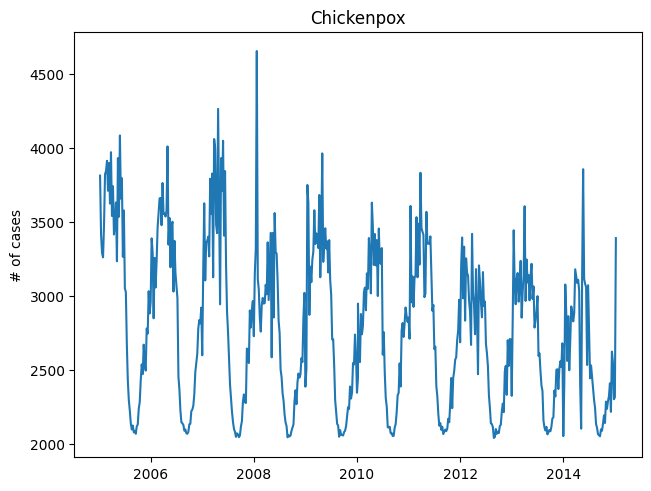

In [29]:
##############################
# Plot data
##############################

fig, ((ax1)) = plt.subplots(1, 1, layout="constrained")

ax1.plot(hungary_chickenpox_data["week"],hungary_chickenpox_data["cases"])
ax1.set_ylabel('# of cases')
ax1.set_title('Chickenpox')

plt.show()

In [32]:
!pip install xlrd openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 5.6 MB/s eta 0:00:00a 0:00:01


Data from https://nepszamlalas2022.ksh.hu/en/database/#/table/WBS003/N4IgFgpghgJiBcBtEAVAogJQKoBkD6A4mgPICsIAugDQgDOAljBAsigJICyaeACpm8QAilGrQgBjAC70A9gDsW1EADN6AG0kQATrQSgA1vTlx4IDlAAOIGhDmSt9CLqStMuQiXJUDRkyADKEJLWIABuUGoArk4sIAASWACMiQAMIQmJAExpNAkAzHmJ6VgFecUFmcWZyVVZtWW5WJnNVdWtDfFNhVV5lY2ZBeV1jYVFI4kd-W0jLTNlFAC-FIsLQA===

In [ ]:
population = pd.read_excel('data/hungary_population.xlsx', skiprows=1)
population=population.rename(columns = {'Unnamed: 0':'Year'})
population.head(3)

,Year,Budapest,Pest vármegye,Fejér vármegye,Komárom-Esztergom vármegye,Veszprém vármegye,Győr-Moson-Sopron vármegye,Vas vármegye,Zala vármegye,Baranya vármegye,...,Tolna vármegye,Borsod-Abaúj-Zemplén vármegye,Heves vármegye,Nógrád vármegye,Hajdú-Bihar vármegye,Jász-Nagykun-Szolnok vármegye,Szabolcs-Szatmár-Bereg vármegye,Bács-Kiskun vármegye,Békés vármegye,Csongrád-Csanád vármegye
0,2022,1685342,1333533,419656,300631,335361,465945,249513,260800,354022,...,207931,623024,285892,182459,519141,355809,529381,495318,315222,391184
1,2011,1729040,1217476,425847,304568,351898,447985,256629,282179,386441,...,230361,686266,308882,202427,546721,386594,559272,520331,359948,417456
2,2001,1777921,1083877,434317,316590,368573,438773,268123,297404,407448,...,249683,744404,325727,220261,552998,415917,582256,546517,397791,433344


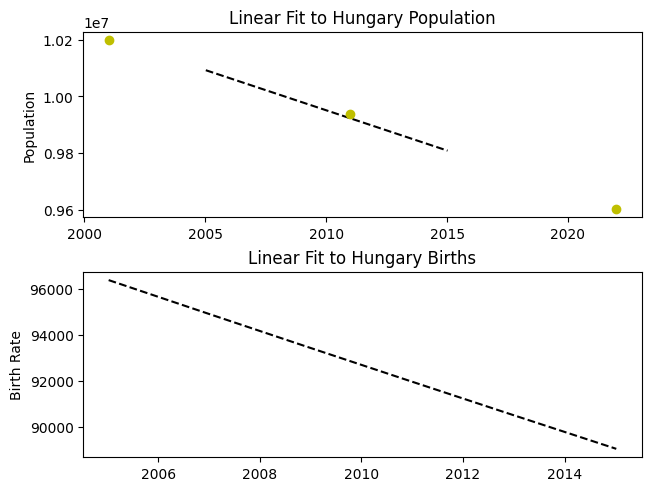

In [87]:
def get_new_population_and_birth_fit(plt_results=False):

    chickenpox_data = load_new_dataset("chickenpox")

    # Load in demographic / birth rate data for Ontario (for Chickenpox)
    hungary_demographics = pd.read_excel('data/hungary_population.xlsx', skiprows=1)
    hungary_demographics = hungary_demographics.rename(columns = {'Unnamed: 0':'week'})
    hungary_demographics["pop"] = np.sum(hungary_demographics.loc[:, hungary_demographics.columns != 'week'], axis=1)

    hungary_birth_data = pd.read_csv('data/hungary_birth_data.txt', sep="\t", header=None)
    hungary_birth_data.columns = ["week", "birthrate"]

    # Linear interpolation to fill in missing week's data:
    hungary_population_growth_lin_fit = np.poly1d(np.polyfit(hungary_demographics["week"],hungary_demographics["pop"],1))
    P = hungary_population_growth_lin_fit(chickenpox_data["week"])

    # d = {
    #     'week': chickenpox_data["week"].values,
    #     'population': P
    # }
    # hungary_demographics_linear = pd.DataFrame(d)

    hungary_birth_data_lin_fit = np.poly1d(np.polyfit(hungary_birth_data["week"],hungary_birth_data["birthrate"],1))
    B = hungary_birth_data_lin_fit(chickenpox_data["week"])
    B = B * P / 1000

    if plt_results:
        fig, ((ax1, ax2)) = plt.subplots(2, 1, layout="constrained")

        ax1.plot(chickenpox_data["week"], P, '--k', hungary_demographics["week"], hungary_demographics["pop"], 'yo')
        ax1.set_ylabel('Population')
        ax1.set_title('Linear Fit to Hungary Population')

        ax2.plot(chickenpox_data["week"], B, '--k')
        ax2.set_ylabel('Birth Rate')
        ax2.set_title('Linear Fit to Hungary Births')
        plt.show()

    return P, B

_, _ = get_new_population_and_birth_fit(True)